<h1 align="center"> IST 5520 Milestone 3: Data Analysis I <h1>
<h3 align="center"> AirBnB Dataset <h3>

#### Student: Ronald Adomako
#### Student: Idris Dobbs
#### Student: Narendra Chigili
#### Student: Nikhil Srirama Sai

# Cleanse and visualize data

## Introduction

AirBnB is a PaaS for the short term rental market. Users use the platform to list residences for short term rentals. We noticed that for big cities, such as New York City, there are many host and some may want to use AirBnB for lucrative means. Given location and characteristics of a property, a new host would want to know whether he or she is charging the optimal amount to rent the space to lodgers.

We noticed that from the New York City dataset for AirBnB, the categorical variable for location  was too coarse. The descriptor says the location is categorized into five boroughs. For a big city such as New York City, there are a lot of insights missing from a business perspective because neighborhoods vary drastically in property amenities even within a single borough. Moreso, the geo-coordinates are too fine for business purposes. To handle this we implement a zip code converter to categorize properties based on their location - Feature Selection.

- What are the largest determinants / predictors of AirBnB rental prices?
- How can we optimize rental revenue based on rental location and other characteristics?
- What price should be charged based on rental location/ characteristics?

We are opperating under the assumption that NYC AirBnB prices has reached a *steady-state*: i.e. the market has been active for long enough in NYC and there are enough data points (observations) in NYC that the **mean** is meaningful.

We want to know whether a host is charging an optimal price. To do this we group the observations by neigborhood and then take the average price. Hosts who charge at or above this price are considered optimal in their respective neighborhood while hosts who charge below the average price for their neighborhood are sub-optimal. Consider the case where all hosts charge the same price within a neighborhood, then the mean is the mode is the median- uniform data, no variance. All the hosts in this neighborhood would be optimal.

Consider the case where one of those hosts charge below what would have been the average, then only that host is sub-optimal while the rest are optimal. Conversely, if one host charge above the rest while everyone else charges the same, then that one host would be optimal while the rest are suboptimal.

Along with the *steady-state* assumption, by grouping the data by neighborhoods we assume that on average homes and amenities are similar by neighborhood. The geo-coordinates are too fine a scale and the boroughs are too coarse a scale. A meso-scale would be by zipcode, which we would expect to have higher precision of similarities between host, or by neighborhood. For a dataset with 39881 observations, transforming geo-coordinates prove to be computationally expensive (22 hours on standard household computer). We chose the next best meso-scale: what AirBnB features as "neighbourhood".

From a business perspective, we want to know what percent of hosts per neighborhood are charging an optimal price, and aggregating this data the percent hosts charge an optimal price in NYC overall. We see that using the neighborhood grouping allows us to compare on a common scale for all hosts. We don't have hosts income, so we wouldn't be able to measure profit. Likewise, revenue wouldn't be a fair scale because hosts with more units will outperform host with smaller units just by volume. A nieghborhood comparison allows a better metric to assess price per room, where we expect reasonably small variance per neighborhood. Furthermore, comparing by percentage is normalizes our comparison in general.

## Data Source and Collection

#### We chose the AirBnB dataset for New York City (NYC). We want to build a model that indicates whether hosts are charging an optimum amount for their rental.

http://insideairbnb.com/new-york-city/

[data dictionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing)

http://insideairbnb.com/get-the-data

http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sidetable as stb
import numpy as np
# import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import seaborn as sb
from scipy import stats as st
import statsmodels as sts
import statsmodels.api as sm
import json
import folium

%matplotlib inline

In [2]:
#data = pd.read_csv('Grp3Project_InitialData/data_dictionary.csv')
data = pd.read_csv('/Users/palaparthisainikhil/Downloads/IST5520GrpProj-milestone3 3/Grp3Project_InitialData/data_dictionary.csv')
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df2 = pd.read_csv(csv_URL)

In [3]:
data_dict = pd.DataFrame(df2.columns, columns=['Features'])
data_dict['Description']=None

In [4]:
d1=pd.read_csv("Brooklyn_zipcodes.csv")
d2=pd.read_csv("Manhattan_zipcodes.csv")
d = pd.concat([d1,d2])

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31692 entries, 0 to 16846
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      31692 non-null  int64  
 1   id                              31692 non-null  float64
 2   name                            31681 non-null  object 
 3   host_id                         31692 non-null  int64  
 4   host_name                       31642 non-null  object 
 5   neighbourhood_group             31692 non-null  object 
 6   neighbourhood                   31692 non-null  object 
 7   latitude                        31692 non-null  float64
 8   longitude                       31692 non-null  float64
 9   room_type                       31692 non-null  object 
 10  price                           31692 non-null  int64  
 11  minimum_nights                  31692 non-null  int64  
 12  number_of_reviews               

### Dimensional Analysis
- What are the largest determinants / predictors of AirBnB rental prices?

The data dictionary for New York City AirBnB dataset consists of 75 columns (variables or features) and 39881 observations. Based on our research question and several [Kaggle challenges](https://www.kaggle.com/search?q=airbnb-listing-in-nyc) (www.kaggle.com/search?q=airbnb-listing-in-nyc) we reduced our dimensions to the following **18** features for preliminary analysis.

In [6]:
for i,feature in enumerate(df2.columns):
    #print(feature)
    #print(type(feature))
    val = data[data['Field']==feature]['Description'].values
    try:
        data_dict.loc[i,'Description'] = val[0]
    except: #IndexError
        data_dict.loc[i,'Description'] = None
        
    if feature == 'neighbourhood':
        data_dict.loc[i,'Description'] = \
            'Neighborhood equivalent for zip code group'
    if feature == 'neighbourhood_group':
        data_dict.loc[i,'Description'] = \
            'Borough'        
        
pd.set_option('display.max_colwidth', 100)
data_dict


,Features,Description
0,id,Airbnb's unique identifier for the listing
1,name,Name of the listing
2,host_id,Airbnb's unique identifier for the host/user
3,host_name,Name of the host. Usually just the first name(s).
4,neighbourhood_group,Borough
5,neighbourhood,Neighborhood equivalent for zip code group
6,latitude,Uses the World Geodetic System (WGS84) projection for latitude and longitude.
7,longitude,Uses the World Geodetic System (WGS84) projection for latitude and longitude.
8,room_type,[Entire home/apt|Private room|Shared room|Hotel]
9,price,daily price in local currency


In [7]:
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df = pd.read_csv(csv_URL)

## Data Manipulation

In [8]:
df['neighbourhood_group'].unique()

array(['Brooklyn', 'Queens', 'Bronx', 'Manhattan', 'Staten Island'],
      dtype=object)

In [9]:
#Create a data frame grouping by neighborhood for average price
hood_price_obj = df[['neighbourhood','price']].groupby('neighbourhood')
df_mean_price = hood_price_obj.mean()
df_mean_price[['price']] = df_mean_price[['price']].round(2)
df_mean_price

,price
neighbourhood,
Allerton,118.78
Arden Heights,113.86
Arrochar,132.06
Arverne,230.26
Astoria,109.01
...,...
Windsor Terrace,175.40
Woodhaven,94.53
Woodlawn,141.00


In [10]:
hood_price_objz = d[['ZipCodes','price','neighbourhood']].groupby('ZipCodes')
df_mean_pricez = hood_price_objz.mean()
df_mean_pricez[['price']] = df_mean_pricez[['price']].round(2)
df_mean_pricez

,price
ZipCodes,
10000.0,173.40
10001.0,312.69
10002.0,280.50
10003.0,258.39
10004.0,315.30
...,...
11238.0,206.36
11239.0,155.12
11249.0,245.05


In [11]:
df_mean_pricez.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 112 entries, 10000.0 to 11385.0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   112 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [12]:
df_mean_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, Allerton to Woodside
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   244 non-null    float64
dtypes: float64(1)
memory usage: 3.8+ KB


**We have reduced 39881 into 244 rows of manageable data!**

In [13]:
df.stb.freq(['neighbourhood'])

,neighbourhood,count,percent,cumulative_count,cumulative_percent
0,Bedford-Stuyvesant,2779,6.968230,2779,6.968230
1,Williamsburg,2456,6.158321,5235,13.126551
2,Harlem,1878,4.709009,7113,17.835561
3,Midtown,1701,4.265189,8814,22.100750
4,Bushwick,1657,4.154861,10471,26.255610
...,...,...,...,...,...
239,Fort Wadsworth,1,0.002507,39877,99.989970
240,Ferry Point Park,1,0.002507,39878,99.992478
241,Country Club,1,0.002507,39879,99.994985
242,Bull's Head,1,0.002507,39880,99.997493


In [14]:
d.stb.freq(['ZipCodes'])

,ZipCodes,count,percent,cumulative_count,cumulative_percent
0,10019.0,1004,4.902583,1004,4.902583
1,10002.0,937,4.575419,1941,9.478002
2,10016.0,745,3.637873,2686,13.115875
3,10025.0,714,3.486498,3400,16.602373
4,10036.0,688,3.359539,4088,19.961912
...,...,...,...,...,...
107,10285.0,2,0.009766,20475,99.980468
108,10278.0,1,0.004883,20476,99.985351
109,10168.0,1,0.004883,20477,99.990234
110,10121.0,1,0.004883,20478,99.995117


In [15]:
#df = df2.sort_values('neighbourhood')
df_hood = df.stb.freq(['neighbourhood'])
df_hood = df_hood.loc[:,'neighbourhood':'percent']
df_hood = df_hood.sort_values('neighbourhood')

In [16]:
df_hoodz = d.stb.freq(['ZipCodes'])
df_hoodz = df_hoodz.loc[:,'ZipCodes':'percent']
df_hoodz = df_hoodz.sort_values('ZipCodes')

In [17]:
df_hood.reset_index(inplace=True)

In [18]:
df_hoodz.reset_index(inplace=True)

In [19]:
df_mean = df_mean_price[['price']].reset_index()
df_mean.head()

,neighbourhood,price
0,Allerton,118.78
1,Arden Heights,113.86
2,Arrochar,132.06
3,Arverne,230.26
4,Astoria,109.01


In [20]:
df_meanz = df_mean_pricez[['price']].reset_index()
df_meanz.head()

,ZipCodes,price
0,10000.0,173.40
1,10001.0,312.69
2,10002.0,280.50
3,10003.0,258.39
4,10004.0,315.30


In [21]:
df_hood['price'] = df_mean['price']
df_hood.rename(columns={'index':'pop_rank'}, inplace=True)
df_hood.head()

,pop_rank,neighbourhood,count,percent,price
0,107,Allerton,45,0.112836,118.78
1,204,Arden Heights,7,0.017552,113.86
2,158,Arrochar,17,0.042627,132.06
3,64,Arverne,110,0.275821,230.26
4,14,Astoria,686,1.720117,109.01


In [22]:
df_hoodz['price'] = df_meanz['price']
df_hoodz.rename(columns={'index':'pop_rank'}, inplace=True)
df_hoodz.head()

,pop_rank,ZipCodes,count,percent,price
0,92,10000.0,10,0.048831,173.40
1,6,10001.0,641,3.130036,312.69
2,1,10002.0,937,4.575419,280.50
3,8,10003.0,600,2.929831,258.39
4,58,10004.0,84,0.410176,315.30


## Data Summarization and Visualization
- How can we optimize rental revenue based on rental location and other characteristics?

*We choose the mode, because the mode remains the same after making corrections for outliers*


### Inspect distribution of top three most populous neighborhoods

In [23]:
df_hood.sort_values(by='pop_rank').head()

,pop_rank,neighbourhood,count,percent,price
12,0,Bedford-Stuyvesant,2779,6.968230,140.85
237,1,Williamsburg,2456,6.158321,183.21
108,2,Harlem,1878,4.709009,164.74
144,3,Midtown,1701,4.265189,381.70
30,4,Bushwick,1657,4.154861,114.35


In [24]:
df2_s1 = df.groupby('neighbourhood').get_group('Bedford-Stuyvesant')
df2_s2 = df.groupby('neighbourhood').get_group('Williamsburg')
df2_s3 = df.groupby('neighbourhood').get_group('Harlem')

In [25]:
df_top3= pd.concat([df2_s1,df2_s2,df2_s3])

In [26]:
df2_s1z = d.groupby('ZipCodes').get_group(11238)
df2_s2z = d.groupby('ZipCodes').get_group(11206)
df2_s3z = d.groupby('ZipCodes').get_group(10026)

In [27]:
df_top3z= pd.concat([df2_s1z,df2_s2z,df2_s3z])

#### Bedford-Stuyvesant

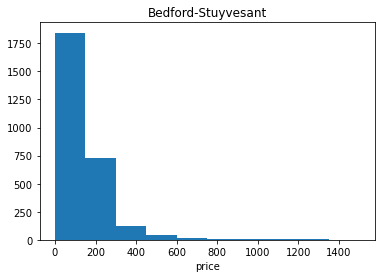

In [28]:
# plt.hist(df2_s1.price, bins=50)
plt.hist(df2_s1.price)
plt.title('Bedford-Stuyvesant')
plt.xlabel('price');

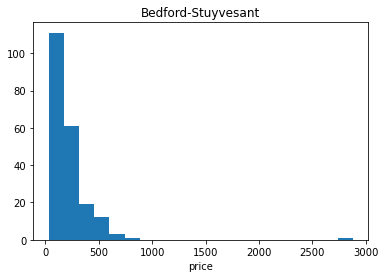

In [29]:
plt.hist(df2_s1z.price, bins=20)
plt.title('Bedford-Stuyvesant')
plt.xlabel('price');

#### Examine extremes of prices - Bed Stuy

In [30]:
top_out = np.log(df2_s1.price).max()
bot_out = np.log(df2_s1.price).min()
print(f'Log of outlier for uncorrected prices: {bot_out,top_out}');

Log of outlier for uncorrected prices: (-inf, 7.313220387090301)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
top_outz = np.log(df2_s1z.price).max()
bot_outz = np.log(df2_s1z.price).min()
print(f'Log of outlier for uncorrected prices: {bot_outz,top_outz}');

Log of outlier for uncorrected prices: (3.4011973816621555, 7.965545573129992)


In [32]:
#prices greater than a dollar ($1)
df2_s1_corrected = df2_s1[df2_s1['price']>1]

top_out = np.log(df2_s1_corrected.price).max()
bot_out = np.log(df2_s1_corrected.price).min()
print(f'Log of outlier for corrected prices: {bot_out,top_out}');

Log of outlier for corrected prices: (2.70805020110221, 7.313220387090301)


In [33]:
df2_s1_correctedz = df2_s1z[df2_s1z['price']>1]

top_outz = np.log(df2_s1_correctedz.price).max()
bot_outz = np.log(df2_s1_correctedz.price).min()
print(f'Log of outlier for corrected prices: {bot_outz,top_outz}');

Log of outlier for corrected prices: (3.4011973816621555, 7.965545573129992)


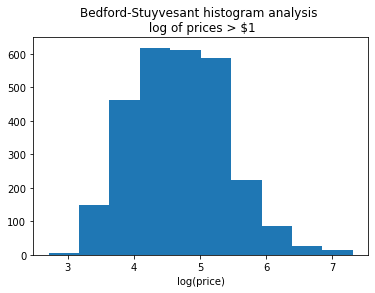

In [34]:
plt.hist(np.log(df2_s1_corrected.price))
plt.title('Bedford-Stuyvesant histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

In [35]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

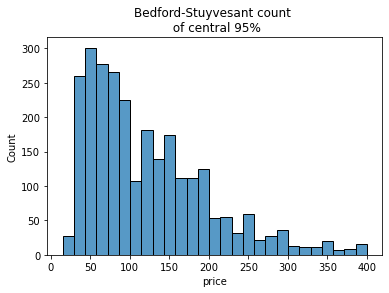

In [36]:
sb.histplot(reject_outliers(df2_s1[ df2_s1['price']>0 ]['price']))
plt.title('Bedford-Stuyvesant count \n of central 95%')
plt.show()

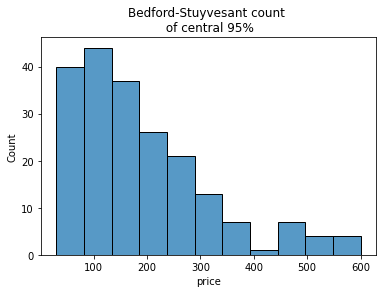

In [37]:
sb.histplot(reject_outliers(df2_s1z[ df2_s1z['price']>0 ]['price']))
plt.title('Bedford-Stuyvesant count \n of central 95%')
plt.show()

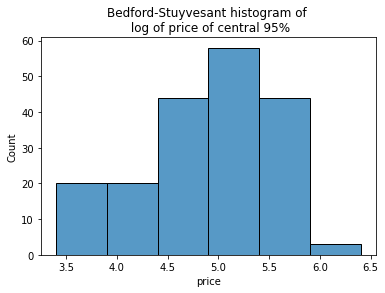

In [38]:
arrayz = reject_outliers(reject_outliers(df2_s1z[ df2_s1z['price']>0 ]['price']))
arrayz.namez = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Bedford-Stuyvesant histogram of \n log of price of central 95%')
plt.show()

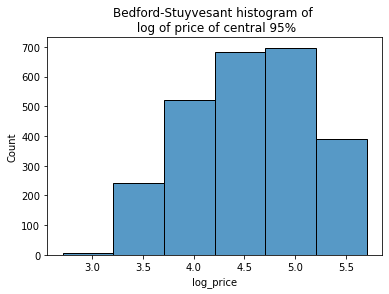

In [39]:
array = reject_outliers(reject_outliers(df2_s1[ df2_s1['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Bedford-Stuyvesant histogram of \n log of price of central 95%')
plt.show()

In [40]:
bed_stuy_mean = np.mean(array)
bed_stuy_median = np.median(array)
bed_stuy_mode = st.mode(array)

print('Bedford Stuyversant\n')
print(f'mean: ${int(bed_stuy_mean)}')
print(f'median: ${int(bed_stuy_median)}')
print(f'mode: ${bed_stuy_mode.mode[0]}')
print(f'count: {len(array)}')

Bedford Stuyversant

mean: $111
median: $98
mode: $150
count: 2540


In [41]:
bed_stuy_meanz = np.mean(arrayz)
bed_stuy_medianz = np.median(arrayz)
bed_stuy_modez = st.mode(arrayz)

print('Bedford Stuyversant\n')
print(f'mean: ${int(bed_stuy_meanz)}')
print(f'median: ${int(bed_stuy_medianz)}')
print(f'mode: ${bed_stuy_modez.mode[0]}')
print(f'count: {len(arrayz)}')

Bedford Stuyversant

mean: $159
median: $150
mode: $90
count: 189


In [42]:
log_array = np.log(array)
bed_stuy_mean = np.mean(log_array)
bed_stuy_median = np.median(log_array)
bed_stuy_mode = st.mode(log_array)

print('Bedford Stuyversant\n')
print(f'mean of log of prices: {round(bed_stuy_mean,2)}')
print(f'median of log of prices: {round(bed_stuy_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_mode.mode[0],2)}')
print(f'count: {len(array)}')

Bedford Stuyversant

mean of log of prices: 4.55
median of log of prices: 4.58 ≠ log(median)
mode of log of prices: 5.01
count: 2540


In [43]:
log_arrayz = np.log(arrayz)
bed_stuy_meanz = np.mean(log_arrayz)
bed_stuy_medianz = np.median(log_arrayz)
bed_stuy_modez = st.mode(log_arrayz)

print('Bedford Stuyversant\n')
print(f'mean of log of prices: {round(bed_stuy_meanz,2)}')
print(f'median of log of prices: {round(bed_stuy_medianz,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Bedford Stuyversant

mean of log of prices: 4.88
median of log of prices: 5.01 ≠ log(median)
mode of log of prices: 4.5
count: 189


### Bed-stuy "Entire Home/ Apt"

In [44]:
df2_bedstuy = df.groupby('neighbourhood').get_group('Bedford-Stuyvesant')
df2_bedstuy;

In [45]:
df2_bedstuy_apt = df2_bedstuy.groupby('room_type').get_group('Entire home/apt')
df2_bedstuy_apt;

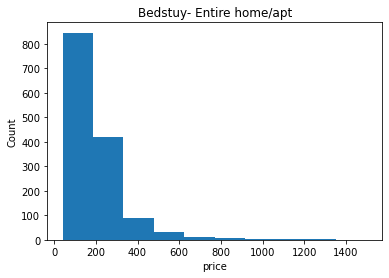

In [46]:
# plt.hist(df2_bedstuy_apt.price, bins=50)
plt.hist(df2_bedstuy_apt.price)
plt.title('Bedstuy- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

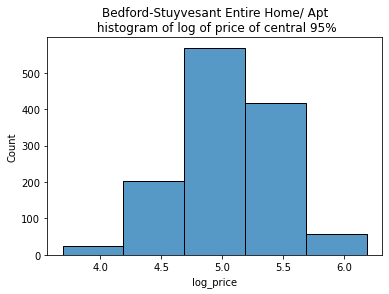

In [47]:
bedstuy_array = reject_outliers(df2_bedstuy_apt[ df2_bedstuy_apt['price']>0 ]['price'])
array = reject_outliers(bedstuy_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Bedford-Stuyvesant Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [48]:
log_array = np.log(array)
bed_stuy_mean = np.mean(log_array)
bed_stuy_median = np.median(log_array)
bed_stuy_mode = st.mode(log_array)

print('Bedford Stuyversant Entire Home/ Apt')
print(f'mean of log of prices: {round(bed_stuy_mean,2)}')
print(f'median of log of prices: {round(bed_stuy_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_mode.mode[0],2)}')
print(f'count: {len(array)}\n')

print(f'log(median): {round(np.log(np.median(array)),2)}')

Bedford Stuyversant Entire Home/ Apt
mean of log of prices: 5.04
median of log of prices: 5.04 ≠ log(median)
mode of log of prices: 5.01
count: 1273

log(median): 5.04


In [49]:
df2_bedstuyz = d.groupby('ZipCodes').get_group(11238)
df2_bedstuyz;

In [50]:
df2_bedstuy_aptz = df2_bedstuyz.groupby('room_type').get_group('Entire home/apt')
df2_bedstuy_aptz;

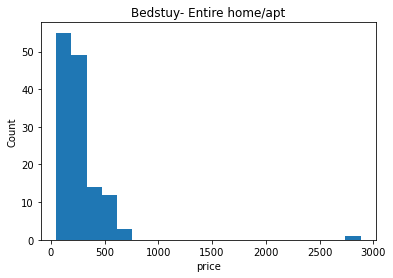

In [51]:
plt.hist(df2_bedstuy_aptz.price, bins=20)
plt.title('Bedstuy- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

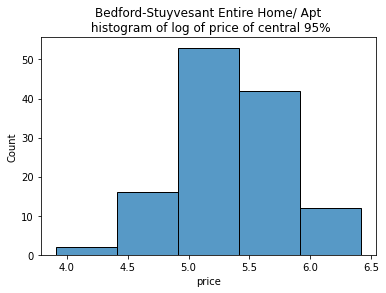

In [52]:
bedstuy_arrayz = reject_outliers(df2_bedstuy_aptz[ df2_bedstuy_aptz['price']>0 ]['price'])
arrayz = reject_outliers(bedstuy_arrayz)
array.namez = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Bedford-Stuyvesant Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [53]:
log_arrayz = np.log(arrayz)
bed_stuy_meanz = np.mean(log_arrayz)
bed_stuy_medianz = np.median(log_arrayz)
bed_stuy_modez = st.mode(log_arrayz)

print('Bedford Stuyversant Entire Home/ Apt')
print(f'mean of log of prices: {round(bed_stuy_meanz,2)}')
print(f'median of log of prices: {round(bed_stuy_medianz,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_modez.mode[0],2)}')
print(f'count: {len(arrayz)}\n')

print(f'log(median): {round(np.log(np.median(arrayz)),2)}')

Bedford Stuyversant Entire Home/ Apt
mean of log of prices: 5.34
median of log of prices: 5.3 ≠ log(median)
mode of log of prices: 5.16
count: 125

log(median): 5.3


#### Williamsburg

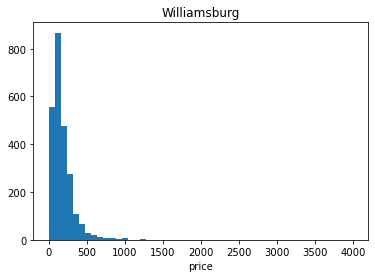

In [54]:
plt.hist(df2_s2.price, bins=50)
plt.title('Williamsburg')
plt.xlabel("price");

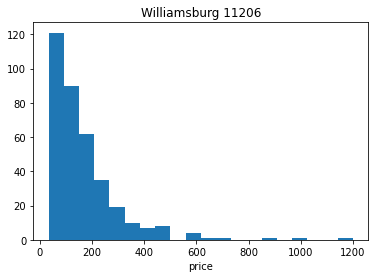

In [55]:
plt.hist(df2_s2z.price, bins=20)
plt.title('Williamsburg 11206')
plt.xlabel("price");

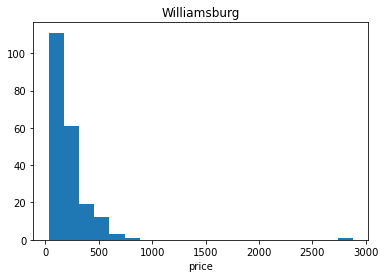

In [56]:
plt.hist(df2_s1z.price, bins=20)
plt.title('Williamsburg')
plt.xlabel('price');

#### Examine extreme of prices - Williamsburg

Log of outlier for uncorrected prices: (-inf, 8.293049139768444)
Log of outlier for corrected prices: (3.0, 8.29)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


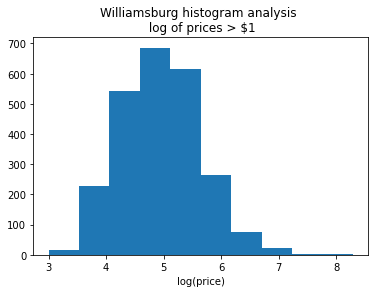

In [57]:
top_out = np.log(df2_s2.price).max()
bot_out = np.log(df2_s2.price).min()
print(f'Log of outlier for uncorrected prices: {bot_out,top_out}')

#prices greater than a dollar ($1)
df2_s2_corrected = df2_s2[df2_s2['price']>1]
top_out = np.log(df2_s2_corrected.price).max()
bot_out = np.log(df2_s2_corrected.price).min()
print(f'Log of outlier for corrected prices: {round(bot_out,2),round(top_out,2)}')

plt.hist(np.log(df2_s2_corrected.price))
plt.title('Williamsburg histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

In [58]:
#### Examine extreme of prices - Williamsburg using zip codes

Log of outlier for uncorrected prices: (3.4965075614664802, 7.090076835776092)
Log of outlier for corrected prices: (3.5, 7.09)


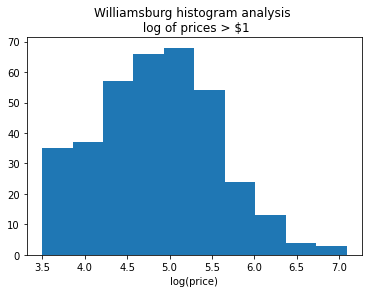

In [59]:
top_outz = np.log(df2_s2z.price).max()
bot_outz = np.log(df2_s2z.price).min()
print(f'Log of outlier for uncorrected prices: {bot_outz,top_outz}')

#prices greater than a dollar ($1)
df2_s2_correctedz = df2_s2z[df2_s2z['price']>1]
top_outz = np.log(df2_s2_correctedz.price).max()
bot_outz = np.log(df2_s2_correctedz.price).min()
print(f'Log of outlier for corrected prices: {round(bot_outz,2),round(top_outz,2)}')

plt.hist(np.log(df2_s2_correctedz.price))
plt.title('Williamsburg histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

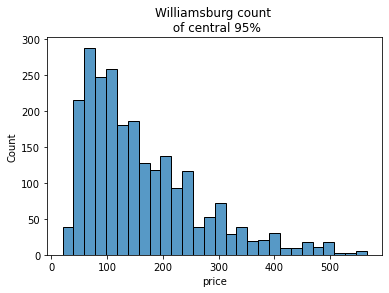

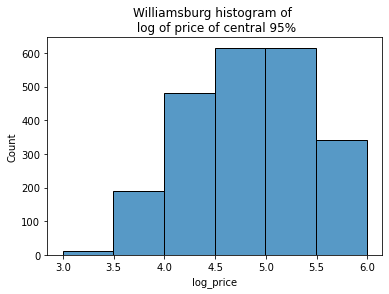

In [60]:
sb.histplot(reject_outliers(df2_s2[ df2_s2['price']>0 ]['price']))
plt.title('Williamsburg count \n of central 95%')
plt.show()

array = reject_outliers(reject_outliers(df2_s2[ df2_s2['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Williamsburg histogram of \n log of price of central 95%')
plt.show()

In [61]:
williamsburg_mean = np.mean(array)
williamsburg_median = np.median(array)
williamsburg_mode = st.mode(array)

print('Williamsburg\n')
print(f'mean: ${int(williamsburg_mean)}')
print(f'median: ${int(williamsburg_median)}')
print(f'mode: ${williamsburg_mode.mode[0]}')
#print(f'count: {len(array)}')

log_array = np.log(array)
williamsburg_mean = np.mean(log_array)
williamsburg_median = np.median(log_array)
williamsburg_mode = st.mode(log_array)
print('\n')
print(f'mean of natural log of prices: {round(williamsburg_mean,2)}')
print(f'median of natural log of prices: {round(williamsburg_median,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(williamsburg_mode.mode[0],2)}')
print(f'count: {len(array)}')

Williamsburg

mean: $144
median: $125
mode: $200


mean of natural log of prices: 4.81
median of natural log of prices: 4.83 ≠ ln(median)
mode of natural log of prices: 5.3
count: 2253


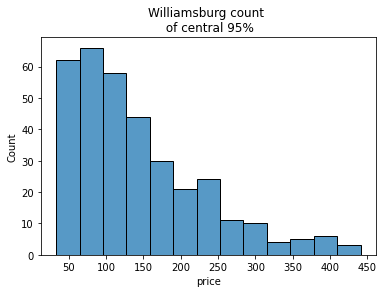

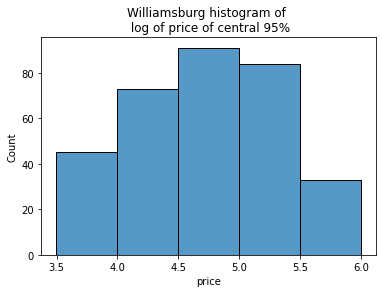

In [62]:
sb.histplot(reject_outliers(df2_s2z[ df2_s2z['price']>0 ]['price']))
plt.title('Williamsburg count \n of central 95%')
plt.show()

arrayz = reject_outliers(reject_outliers(df2_s2z[ df2_s2z['price']>0 ]['price']))
array.namez = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Williamsburg histogram of \n log of price of central 95%')
plt.show()

In [63]:
williamsburg_mean = np.mean(arrayz)
williamsburg_median = np.median(arrayz)
williamsburg_mode = st.mode(arrayz)

print('Williamsburg\n')
print(f'mean: ${int(williamsburg_mean)}')
print(f'median: ${int(williamsburg_median)}')
print(f'mode: ${williamsburg_mode.mode[0]}')
#print(f'count: {len(array)}')

log_arrayz = np.log(arrayz)
williamsburg_meanz = np.mean(log_arrayz)
williamsburg_medianz = np.median(log_arrayz)
williamsburg_modez = st.mode(log_arrayz)
print('\n')
print(f'mean of natural log of prices: {round(williamsburg_meanz,2)}')
print(f'median of natural log of prices: {round(williamsburg_medianz,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(williamsburg_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Williamsburg

mean: $128
median: $109
mode: $38


mean of natural log of prices: 4.7
median of natural log of prices: 4.7 ≠ ln(median)
mode of natural log of prices: 3.64
count: 326


### Williamsburg "Entire Home/ Apt"

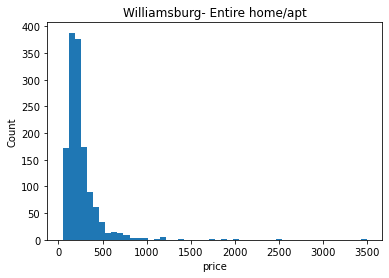

In [64]:
df2_williamsburg = df.groupby('neighbourhood').get_group('Williamsburg')
df2_williamsburg_apt = df2_williamsburg.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_williamsburg_apt.price, bins=50)
plt.title('Williamsburg- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

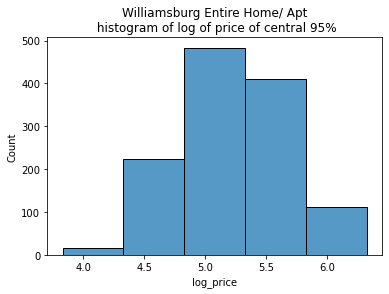

In [65]:
williamsburg_array = reject_outliers(df2_williamsburg_apt[ df2_williamsburg_apt['price']>0 ]['price'])
array = reject_outliers(williamsburg_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Williamsburg Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [66]:
log_array = np.log(array)
williamsburg_mean = np.mean(log_array)
williamsburg_median = np.median(log_array)
williamsburg_mode = st.mode(log_array)

print('Williamsburg Entire Home/ Apt\n')
print(f'mean of log of prices: {round(williamsburg_mean,2)}')
print(f'median of log of prices: {round(williamsburg_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(williamsburg_mode.mode[0],2)}')
print(f'count: {len(array)}')

Williamsburg Entire Home/ Apt

mean of log of prices: 5.25
median of log of prices: 5.28 ≠ log(median)
mode of log of prices: 5.3
count: 1244


In [67]:
### Williamsburg "Entire Home/ Apt" with zipcodes

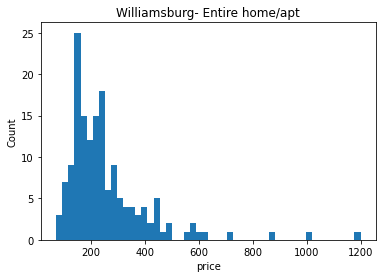

In [68]:
df2_williamsburgz = d.groupby('ZipCodes').get_group(11206)
df2_williamsburg_aptz = df2_williamsburgz.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_williamsburg_aptz.price, bins=50)
plt.title('Williamsburg- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

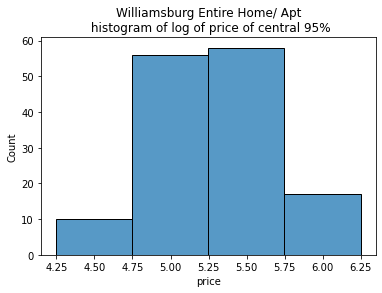

In [69]:
williamsburg_arrayz = reject_outliers(df2_williamsburg_aptz[ df2_williamsburg_aptz['price']>0 ]['price'])
arrayz = reject_outliers(williamsburg_arrayz)
array.name = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Williamsburg Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [70]:
log_arrayz = np.log(arrayz)
williamsburg_meanz = np.mean(log_arrayz)
williamsburg_medianz = np.median(log_arrayz)
williamsburg_modez = st.mode(log_arrayz)

print('Williamsburg Entire Home/ Apt\n')
print(f'mean of log of prices: {round(williamsburg_meanz,2)}')
print(f'median of log of prices: {round(williamsburg_medianz,2)} ≠ log(median)')
print(f'mode of log of prices: {round(williamsburg_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Williamsburg Entire Home/ Apt

mean of log of prices: 5.31
median of log of prices: 5.32 ≠ log(median)
mode of log of prices: 5.01
count: 141


#### Harlem

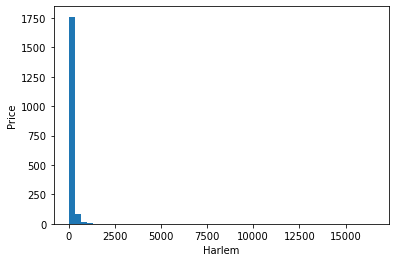

In [71]:
plt.hist(df2_s3.price,bins = 50)
plt.xlabel('Harlem')
plt.ylabel("Price");

In [72]:
#### Harlem with ZipCodes

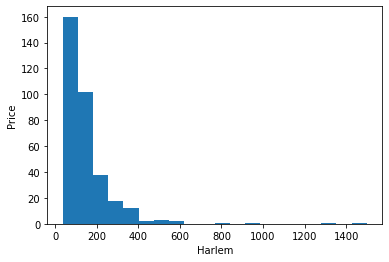

In [73]:
plt.hist(df2_s3z.price,bins = 20)
plt.xlabel('Harlem')
plt.ylabel("Price");

#### Examine extreme of prices - Harlem

Log of outlier for uncorrected prices: (2.3, 9.71)
Log of outlier for corrected prices: (2.3, 9.71)


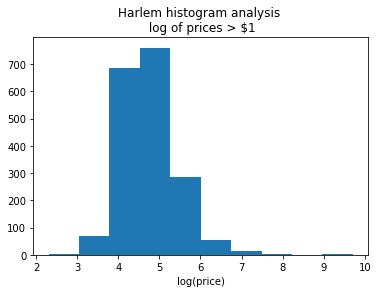

In [74]:
top_out = np.log(df2_s3.price).max()
bot_out = np.log(df2_s3.price).min()
print(f'Log of outlier for uncorrected prices: {round(bot_out,2),round(top_out,2)}')

#prices greater than a dollar ($1)
df2_s3_corrected = df2_s3[df2_s3['price']>1]
top_out = np.log(df2_s3_corrected.price).max()
bot_out = np.log(df2_s3_corrected.price).min()
print(f'Log of outlier for corrected prices: {round(bot_out,2),round(top_out,2)}')

plt.hist(np.log(df2_s3_corrected.price))
plt.title('Harlem histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

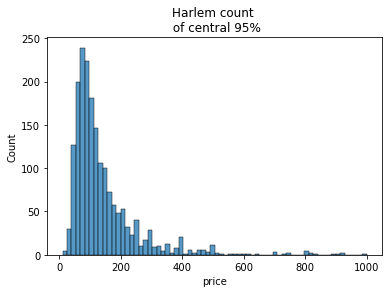

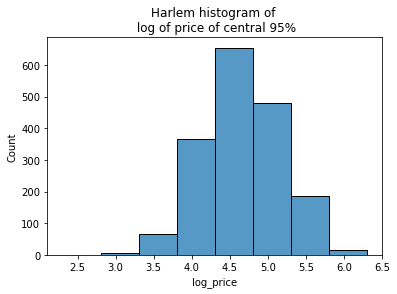

In [75]:
sb.histplot(reject_outliers(df2_s3[ df2_s3['price']>0 ]['price']))
plt.title('Harlem count \n of central 95%')
plt.show()

array = reject_outliers(reject_outliers(df2_s3[ df2_s3['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Harlem histogram of \n log of price of central 95%')
plt.show()

In [76]:
harlem_mean = np.mean(array)
harlem_median = np.median(array)
harlem_mode = st.mode(array)

print('Harlem\n')
print(f'mean: ${int(harlem_mean)}')
print(f'median: ${int(harlem_median)}')
print(f'mode: ${harlem_mode.mode[0]}')
#print(f'count: {len(array)}')

log_array = np.log(array)
harlem_mean = np.mean(log_array)
harlem_median = np.median(log_array)
harlem_mode = st.mode(log_array)
print('\n')
print(f'mean of natural log of prices: {round(harlem_mean,2)}')
print(f'median of natural log of prices: {round(harlem_median,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(harlem_mode.mode[0],2)}')
print(f'count: {len(array)}')

Harlem

mean: $121
median: $100
mode: $100


mean of natural log of prices: 4.66
median of natural log of prices: 4.61 ≠ ln(median)
mode of natural log of prices: 4.61
count: 1774


Log of outlier for uncorrected prices: (3.56, 7.31)
Log of outlier for corrected prices: (3.56, 7.31)


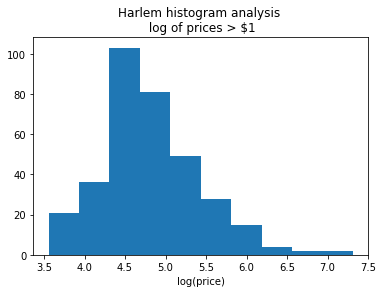

In [77]:
top_outz = np.log(df2_s3z.price).max()
bot_outz = np.log(df2_s3z.price).min()
print(f'Log of outlier for uncorrected prices: {round(bot_outz,2),round(top_outz,2)}')

#prices greater than a dollar ($1)
df2_s3_correctedz = df2_s3z[df2_s3z['price']>1]
top_outz = np.log(df2_s3_correctedz.price).max()
bot_outz = np.log(df2_s3_correctedz.price).min()
print(f'Log of outlier for corrected prices: {round(bot_outz,2),round(top_outz,2)}')

plt.hist(np.log(df2_s3_correctedz.price))
plt.title('Harlem histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

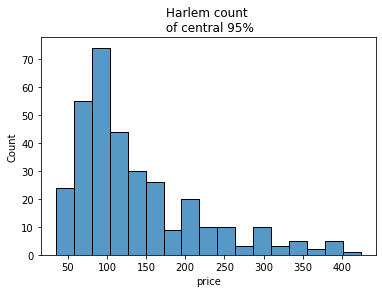

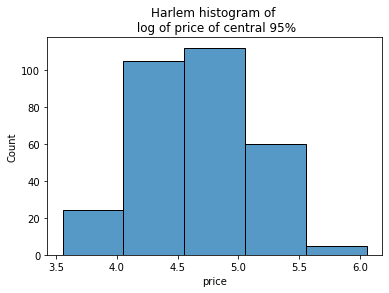

In [78]:
sb.histplot(reject_outliers(df2_s3z[ df2_s3z['price']>0 ]['price']))
plt.title('Harlem count \n of central 95%')
plt.show()

arrayz = reject_outliers(reject_outliers(df2_s3z[ df2_s3z['price']>0 ]['price']))
array.namez = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Harlem histogram of \n log of price of central 95%')
plt.show()

In [79]:
harlem_meanz = np.mean(arrayz)
harlem_medianz = np.median(arrayz)
harlem_modez = st.mode(arrayz)

print('Harlem\n')
print(f'mean: ${int(harlem_meanz)}')
print(f'median: ${int(harlem_medianz)}')
print(f'mode: ${harlem_modez.mode[0]}')
#print(f'count: {len(array)}')

log_arrayz = np.log(arrayz)
harlem_meanz = np.mean(log_arrayz)
harlem_medianz = np.median(log_arrayz)
harlem_modez = st.mode(log_arrayz)
print('\n')
print(f'mean of natural log of prices: {round(harlem_meanz,2)}')
print(f'median of natural log of prices: {round(harlem_medianz,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(harlem_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Harlem

mean: $119
median: $102
mode: $100


mean of natural log of prices: 4.69
median of natural log of prices: 4.63 ≠ ln(median)
mode of natural log of prices: 4.61
count: 306


### Harlem "Entire Home/ Apt"

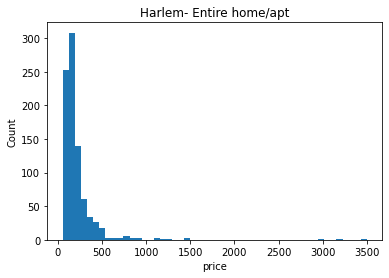

In [80]:
df2_harlem = df.groupby('neighbourhood').get_group('Harlem')
df2_harlem_apt = df2_harlem.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_harlem_apt.price, bins=50)
plt.title('Harlem- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

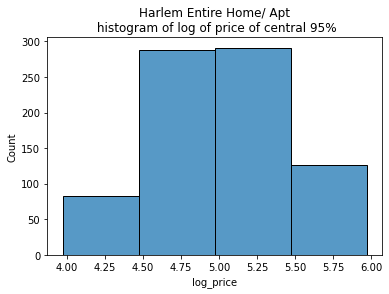

In [81]:
harlem_array = reject_outliers(df2_harlem_apt[ df2_harlem_apt['price']>0 ]['price'])
array = reject_outliers(harlem_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Harlem Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [82]:
log_array = np.log(array)
harlem_mean = np.mean(log_array)
harlem_median = np.median(log_array)
harlem_mode = st.mode(log_array)

print('Harlem Entire Home/ Apt\n')
print(f'mean of log of prices: {round(harlem_mean,2)}')
print(f'median of log of prices: {round(harlem_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(harlem_mode.mode[0],2)}')
print(f'count: {len(array)}')

Harlem Entire Home/ Apt

mean of log of prices: 5.01
median of log of prices: 5.01 ≠ log(median)
mode of log of prices: 5.01
count: 789


In [83]:
#### Harlem Entire Home/Apt using ZipCodes

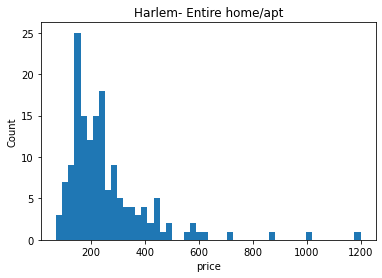

In [84]:
df2_harlemz = d.groupby('ZipCodes').get_group(11206)
df2_harlem_aptz = df2_harlemz.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_harlem_aptz.price, bins=50)
plt.title('Harlem- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

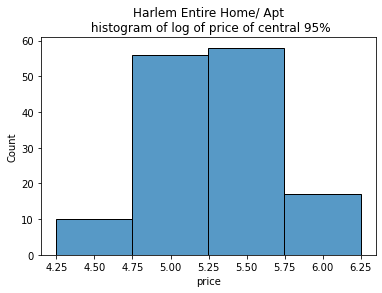

In [85]:
harlem_arrayz = reject_outliers(df2_harlem_aptz[ df2_harlem_aptz['price']>0 ]['price'])
arrayz = reject_outliers(harlem_arrayz)
array.name = 'log_price'

sb.histplot(np.log(arrayz), binwidth=0.5)
plt.title('Harlem Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [86]:
log_arrayz = np.log(arrayz)
harlem_meanz = np.mean(log_arrayz)
harlem_medianz = np.median(log_arrayz)
harlem_modez = st.mode(log_arrayz)

print('Harlem Entire Home/ Apt\n')
print(f'mean of log of prices: {round(harlem_meanz,2)}')
print(f'median of log of prices: {round(harlem_medianz,2)} ≠ log(median)')
print(f'mode of log of prices: {round(harlem_modez.mode[0],2)}')
print(f'count: {len(arrayz)}')

Harlem Entire Home/ Apt

mean of log of prices: 5.31
median of log of prices: 5.32 ≠ log(median)
mode of log of prices: 5.01
count: 141


#### Interpretation

The aim was to get a normally distributed curve for our assumptions in obtaining a mean price per night. Without correcting for outliers, the data seems to approach a logarithmic or skewed normally distributed curve, in which case taking the median or mode for the optimum price would be most appropriate. We choose the mode, since this measure is more stable as it directly depends on the y-axis of the histogram where as the mean and median directly depends on the x-axis.

### Proportion of AirBNB Listings by Borough and Room Type in NYC

The 1st pie chart shows 95% of the AirBnB listings are in Manhattan, Brooklyn and Queens. Brooklyn and Staten Island make up the remaining listings. Manhattan and Brooklyn alone make up neary 80% of the listings.

The 2nd pie chart shows the listings distributed by room type. Most of the observations consist of entire home / apartments, or private rooms. Hotel and shared rooms are an insignificant proportion of the distribution.

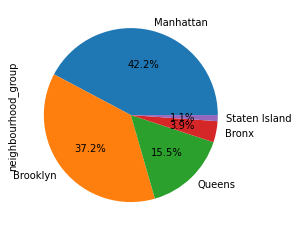

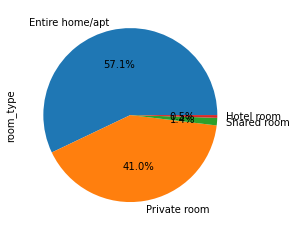

In [87]:
#Create a pie chart showing the percentage of listings per bourrough.
df1 = df.neighbourhood_group.value_counts()
df1.plot.pie(autopct="%.1f%%")
plt.show()

df2 = df.room_type.value_counts()
df2.plot.pie(autopct="%.1f%%")
plt.show()

### NYC AirBNB Listing Price Statistics by Borough

The table and box/whisker plots above provide illustration of the frequency, price statistics, and price distribution by neighborhood group or burrough in New York City. There is wide variability in the observations, with standard deviations consistently higher than the mean for each burrough. Mean prices are consistently higher than the median price, which suggest the prevalance of high values or outliers in the dataset that are pulling up the average. Average prices are highest in Manhattan, Brooklyn, and Queens respectively.

neighbourhood_group       price                         \
                                  count        mean median         std min   
neighbourhood_group                                                          
Bronx                              1568  124.737245   90.0  278.572839   0   
Brooklyn                          14845  157.927114  115.0  209.526092   0   
Manhattan                         16847  264.933341  175.0  473.171623   0   
Queens                             6175  131.365506   94.0  213.120396   0   
Staten Island                       446  143.163677  103.5  194.997315  33   

                            
                       max  
neighbourhood_group         
Bronx                 9994  
Brooklyn             10000  
Manhattan            16500  
Queens               10000  
Staten Island         2500

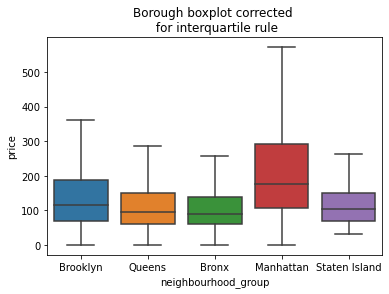

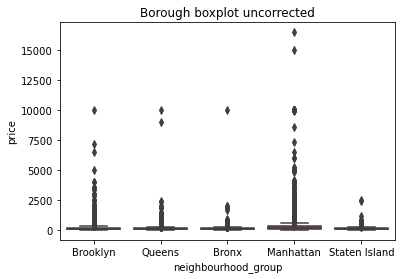

In [88]:
#Display the table of price statistics and counts by New York City burrough.
display(df.groupby('neighbourhood_group').aggregate({'neighbourhood_group':'count',
                                    'price':['mean','median','std','min','max']}))

#Plot boxplot with outliers turned off.
sb.boxplot(y = df['price'], 
            x = df['neighbourhood_group'], 
            showfliers = False)
plt.title('Borough boxplot corrected \n for interquartile rule')
plt.show()

sb.boxplot(y = df['price'], x = df['neighbourhood_group'], showfliers = True)
plt.title('Borough boxplot uncorrected')
plt.show()

### NYC AirBNB Listing Price Statistics by Room Type
The table and box/whisker plots above provide illustration of the frequency, price statistics, and price distribution by room type in New York City. As in the distribution by borough section, there is wide variuability with standard deviations consistently higher than the mean for each burrough (Hotel rooms being the exception). Mean prices are also consistently higher than the median price, which suggest the prevalance of high values or outliers in the dataset that are pulling up the average. Comparisons of the 1st boxplot (corrected for outliers) with the second (not corrected for outliers bear this out.

#### Major Room Type Categories
These categories encompass 98% of the listings and are likely to be more useful for informing business decisions.
- Entire home/apt: Entire residences make up 57% of the dataset and are the category with the second highest average price. Prices range from \\$10 to \\$15K which could be indicative of data errors and/ or outliers.
- Private room: Private rooms constitute 42% of the listings in the data and are the category with the third highest average price. Prices range from \\$10 to \\$16.5K which could be indicative of data errors and/ or outliers.

#### Minor Room Type Categories
Categories that are a significantly smaller number of the overall listings in the dataset. They are less likely to be useful for informing business decisions.
- Shared room: Shared rooms constitute 1.4% of the listings with the lowest average price of all room type categories. Prices range from \\$10 to \\$10K which seems to indicate data entry errors and/or outliers.
- Hotel room: Hotel rooms seem to have the highest average price and the least number of observations. This is the only category where the standard deviation is less than the mean, which suggest a more limited number of high priced outliers.


room_type       price                              
                    count        mean median         std min    max
room_type                                                          
Entire home/apt     22761  251.546022    180  338.044654  10  15000
Hotel room            202  371.648515    291  303.482491   0   1998
Private room        16361  122.936495     75  356.373737  10  16500
Shared room           557  119.398564     66  454.106078  10  10000

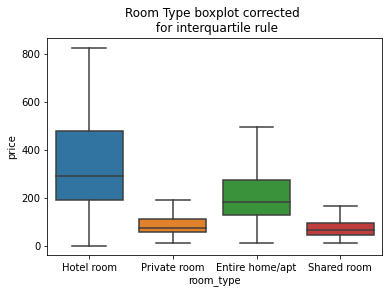

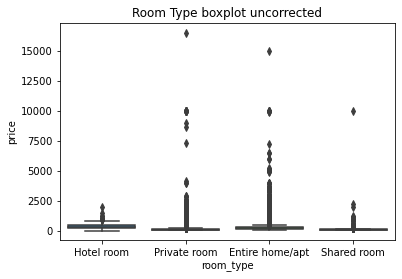

In [89]:
#Display the table of price statistics and counts by New York City burrough.
display(df.groupby('room_type').aggregate({'room_type':'count','price':['mean', 'median','std','min','max']}))

#Plot boxplot with outliers turned off.
sb.boxplot(y = df['price'], x = df['room_type'], showfliers = False)
plt.title('Room Type boxplot corrected \n for interquartile rule')
plt.show()
sb.boxplot(y = df['price'], x = df['room_type'], showfliers = True,saturation=0.75)
plt.title('Room Type boxplot uncorrected')
plt.show()

### AirBNB Listings Statistics by Borough and Room Type in NYC
The listings dataset was aggregated by borough and room type for statistical analysis. The results underscore the need to remove outliers and illogical values from the data.

In [90]:
#Show price statistics by neighborhood group and room type
df_borrough = df[[ 'neighbourhood_group', 'room_type','price']]
display(df_borrough.groupby(['neighbourhood_group', 'room_type']).aggregate({'count',
    'mean', 'median','std', 'min', 'max'}))

price                                     \
                                    median         std min    max        mean   
neighbourhood_group room_type                                                   
Bronx               Entire home/apt    130  156.115405  28   2000  164.569293   
                    Hotel room           0         NaN   0      0    0.000000   
                    Private room        65  356.925302  11   9994   90.527112   
                    Shared room         35  124.059423  10    775   70.447368   
Brooklyn            Entire home/apt    169  228.702022  30   7184  216.452539   
                    Hotel room         145  194.204860   0    529  177.555556   
                    Private room        69  157.575675  10  10000   86.907680   
                    Shared room         45   84.576582  15   1000   70.389535   
Manhattan           Entire home/apt    205  420.865138  29  15000  300.645829   
                    Hotel room         307  308.268374   0   1998  392.163934   
                    Private room       100  549.384274  10  16500  194.915346   
                    Shared room         82  662.012440  29  10000  175.124000   
Queens              Entire home/apt    150  245.295887  10  10000  191.693713   
                    Hotel room         209   89.324471   0    282  189.888889   
                    Private room        65  169.268863  19   9000   83.118776   
                    Shared room         50  156.164089  16   1250   82.093750   
Staten Island       Entire home/apt    129  236.437035  39   2500  180.487179   
                    Private room        68   65.521555  33    500   84.412791   
                    Shared room         59         NaN  59     59   59.000000   

                                            
                                     count  
neighbourhood_group room_type               
Bronx               Entire home/apt    736  
                    Hotel room           1  
                    Private room       793  
                    Shared room         38  
Brooklyn            Entire home/apt   8154  
                    Hotel room           9  
                    Private room      6510  
                    Shared room        172  
Manhattan           Entire home/apt  10862  
                    Hotel room         183  
                    Private room      5552  
                    Shared room        250  
Queens              Entire home/apt   2736  
                    Hotel room           9  
                    Private room      3334  
                    Shared room         96  
Staten Island       Entire home/apt    273  
                    Private room       172  
                    Shared room          1

### Correlation Matrix
A correlation matrix was conducted for the listings data. At this point, most of the factors appear to be weakly correlated with price, which is the primary variable of concern.

In [91]:
df.corr(method='pearson')

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
id,1.000000,0.335359,-0.004366,0.079277,0.047596,-0.119177,-0.185724,0.246370,0.040260,0.286508,-0.080899
host_id,0.335359,1.000000,0.027405,0.144694,0.039558,-0.147641,-0.095511,0.271079,-0.024191,0.247358,0.126596
latitude,-0.004366,0.027405,1.000000,0.048995,0.027974,0.030504,-0.033748,-0.037751,0.033737,-0.018182,-0.034825
longitude,0.079277,0.144694,0.048995,1.000000,-0.123122,-0.083799,0.041505,0.102208,-0.071354,0.123042,0.057616
price,0.047596,0.039558,0.027974,-0.123122,1.000000,-0.035304,-0.032691,0.019562,0.042761,0.095482,-0.002458
minimum_nights,-0.119177,-0.147641,0.030504,-0.083799,-0.035304,1.000000,-0.138135,-0.227912,0.117108,-0.061480,-0.201601
number_of_reviews,-0.185724,-0.095511,-0.033748,0.041505,-0.032691,-0.138135,1.000000,0.520748,-0.092435,0.085598,0.640901
reviews_per_month,0.246370,0.271079,-0.037751,0.102208,0.019562,-0.227912,0.520748,1.000000,-0.029656,0.209944,0.815119
calculated_host_listings_count,0.040260,-0.024191,0.033737,-0.071354,0.042761,0.117108,-0.092435,-0.029656,1.000000,0.125885,-0.051553
availability_365,0.286508,0.247358,-0.018182,0.123042,0.095482,-0.061480,0.085598,0.209944,0.125885,1.000000,0.144143


## Map Visualization of the Distribution of Price by Neighborhood in NYC

This section provides analysis on the distribution of price by neighborhood. The mean price by neighborhood was computed from the data, keyed on a geojson file and incorporated into a folium map. There are several clusters of relatively higher prices, but the most significant one is around the Manhattan area.

## Conclusion and TakeAways

- Average listing prices for Manhattan tend to be the highest, followed by Brooklyn, Queens, Staten Island, and the Bronx. Most of the listings are in Manhattan, Brooklyn, and Queens.

- Entire residences/apartments and private rooms comprise ~97% of the listings here. Hotels and shared rooms are less than 2% of the dataset. Hotels tend to have the highest average price followed by residences, private rooms, and lastly shared rooms. Any predictive model underlying algorithms should be differentiated by room type. In terms of business analytics utility, residences and private rooms seem to be the most promising, while hotels and shared rooms may be less useful due to the relatively limited amount of data.
- The variability in the data is significant. The data should be disaggregated by room type, and all values greater than the 3rd quartile + (1.5 * IQR) should be removed. also, all zero values should also be removed.
- It is hypothesized that properties closer to either Manhattan or other significant attractions will have higher list prices ceteris paribus.

# Regression analysis
- What price should be charged based on rental location/ characteristics?

### Clean dataset

In [96]:
hood_price_obj.mean()

,price
neighbourhood,
Allerton,118.777778
Arden Heights,113.857143
Arrochar,132.058824
Arverne,230.263636
Astoria,109.008746
...,...
Windsor Terrace,175.403509
Woodhaven,94.529412
Woodlawn,141.000000


In [97]:
neighborhood = df['neighbourhood'].unique()
neighborhood.sort()
modes=[st.mode(hood_price_obj.get_group(arr)).mode[0][-1] for arr in neighborhood]
counts=[st.mode(hood_price_obj.get_group(arr)).count[0][0] for arr in neighborhood]

neighborhood = df['neighbourhood'].unique()
neighborhood.sort()

df_aux = hood_price_obj.mean()
df_aux['mean']  = df_aux['price'].round(2)
df_aux['median'] = hood_price_obj.median().round(2)
df_aux['mode'] = pd.DataFrame(np.array(modes), index=df_aux.index)
df_aux['count'] = pd.DataFrame(np.array(counts), index=df_aux.index)
df_aux

,price,mean,median,mode,count
neighbourhood,,,,,
Allerton,118.777778,118.78,108.0,85,45
Arden Heights,113.857143,113.86,107.0,40,7
Arrochar,132.058824,132.06,102.0,75,17
Arverne,230.263636,230.26,167.0,100,110
Astoria,109.008746,109.01,82.0,60,686
...,...,...,...,...,...
Windsor Terrace,175.403509,175.40,150.0,150,114
Woodhaven,94.529412,94.53,75.0,55,85
Woodlawn,141.000000,141.00,106.0,43,7


In [98]:
dat = df.loc[:,'neighbourhood_group':'number_of_reviews_ltm']
dat[['mean_price']] = None
dat[['mode_price']] = None
dat[['median_price']] = None
dat[['count_hood']] = None

for n in df_aux.index:
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'mean_price'] = df_aux.loc[n,'mean']
    
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'mode_price'] = df_aux.loc[n,'mode']
    
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'median_price'] = df_aux.loc[n,'median']
    
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'count_hood'] = df_aux.loc[n,'count']
    
dat

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,mean_price,mode_price,median_price,count_hood
0,Brooklyn,Greenpoint,40.737770,-73.953660,Hotel room,308,2,42,2022-07-18,0.30,30,217,4,198.15,150,150.5,708
1,Brooklyn,Kensington,40.645290,-73.972380,Private room,299,30,9,2018-10-19,0.11,9,356,0,151.76,35,85.0,117
2,Queens,Ridgewood,40.703090,-73.899630,Entire home/apt,425,30,13,2019-11-12,0.10,6,365,0,106.47,50,78.0,315
3,Bronx,Mott Haven,40.806350,-73.922010,Private room,60,30,0,NaN,NaN,1,83,0,136.97,65,99.5,92
4,Manhattan,Morningside Heights,40.806300,-73.959850,Private room,75,31,135,2022-07-11,0.95,1,219,4,134.1,80,100.0,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,Manhattan,Ellis Island,40.718220,-74.037940,Entire home/apt,135,365,2,2019-09-16,0.04,7,365,0,198.28,260,178.0,79
39877,Queens,Rosedale,40.647244,-73.720088,Entire home/apt,180,1,5,2022-08-24,1.92,1,0,5,127.24,90,100.0,147
39878,Manhattan,Upper West Side,40.787320,-74.004470,Entire home/apt,240,5,18,2022-08-22,2.87,1,152,18,231.74,150,157.0,1630
39879,Brooklyn,Williamsburg,40.709192,-73.970121,Entire home/apt,400,30,0,NaN,NaN,1,311,0,183.21,200,136.0,2456


#### *analyze neighborhoods that have more than 30 observations*
https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/

In [99]:
dat_strap = dat[dat['count_hood']>30]
dat_strap

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,mean_price,mode_price,median_price,count_hood
0,Brooklyn,Greenpoint,40.737770,-73.953660,Hotel room,308,2,42,2022-07-18,0.30,30,217,4,198.15,150,150.5,708
1,Brooklyn,Kensington,40.645290,-73.972380,Private room,299,30,9,2018-10-19,0.11,9,356,0,151.76,35,85.0,117
2,Queens,Ridgewood,40.703090,-73.899630,Entire home/apt,425,30,13,2019-11-12,0.10,6,365,0,106.47,50,78.0,315
3,Bronx,Mott Haven,40.806350,-73.922010,Private room,60,30,0,NaN,NaN,1,83,0,136.97,65,99.5,92
4,Manhattan,Morningside Heights,40.806300,-73.959850,Private room,75,31,135,2022-07-11,0.95,1,219,4,134.1,80,100.0,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,Manhattan,Ellis Island,40.718220,-74.037940,Entire home/apt,135,365,2,2019-09-16,0.04,7,365,0,198.28,260,178.0,79
39877,Queens,Rosedale,40.647244,-73.720088,Entire home/apt,180,1,5,2022-08-24,1.92,1,0,5,127.24,90,100.0,147
39878,Manhattan,Upper West Side,40.787320,-74.004470,Entire home/apt,240,5,18,2022-08-22,2.87,1,152,18,231.74,150,157.0,1630
39879,Brooklyn,Williamsburg,40.709192,-73.970121,Entire home/apt,400,30,0,NaN,NaN,1,311,0,183.21,200,136.0,2456


## Logistic Regression

In [100]:
update = dat_strap['price'] >= dat_strap['mode_price'] 
target = pd.get_dummies(update).iloc[:,0]

### Fit model with Data

In [101]:
#Numerical type, same column size unless int

X = pd.DataFrame({'Const':1,
#     'neighbourhood_group':pd.get_dummies(dat_strap['neighbourhood_group']),#.iloc[:,0],
#     'neighbourhood':pd.get_dummies(dat_strap['neighbourhood']),#.iloc[:,0],
#     'room_type':pd.get_dummies(dat_strap['room_type']),#.iloc[:,0],
    'price':dat_strap['price'],#.iloc[:,0],
    'minimum_nights':dat_strap['minimum_nights'],#.iloc[:,0],
    'number_of_reviews':dat_strap['number_of_reviews'],#.iloc[:,0],
    'availability_365':dat_strap['availability_365'],#.iloc[:,0],
    'number_of_reviews_ltm':dat_strap['number_of_reviews_ltm']})

In [102]:
# Describe the logistic model
mod = sm.Logit(target,X)

# Fit model
fit = mod.fit()

# Summarize model
fit.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 9


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                38545
Model:                          Logit   Df Residuals:                    38539
Method:                           MLE   Df Model:                            5
Date:                Sun, 04 Dec 2022   Pseudo R-squ.:                     inf
Time:                        21:59:09   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Const                     2.3755      0.036     65.699      0.000       2.305       2.446
price                    -0.0202      0.000    -81.518      0.000      -0.021      -0.020
minimum_nights            0.0063      0.001     11.306      0.000       0.005       0.007
number_of_reviews         0.0018      0.000      6.325      0.000       0.001       0.002
availability_365         -0.0017   9.82e-05    -17.491      0.000      -0.002      -0.002
number_of_reviews_ltm    -0.0103      0.001     -8.629      0.000      -0.013      -0.008
=========================================================================================
"""

In [103]:
fit.params

Const                    2.375457
price                   -0.020214
minimum_nights           0.006300
number_of_reviews        0.001830
availability_365        -0.001718
number_of_reviews_ltm   -0.010269
dtype: float64

It is not straight forward to interpret coefficients of the logistic regression. Here, we show average marginal effects.

In [104]:
# Calculate average marginal effects
mfx = fit.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
price                    -0.0031   2.19e-05   -140.080      0.000      -0.003      -0.003
minimum_nights            0.0010   8.41e-05     11.377      0.000       0.001       0.001
number_of_reviews         0.0003   4.38e-05      6.338      0.000       0.000       0.000
availability_365         -0.0003   1.47e-05    -17.786      0.000      -0.000      -0.000
number_of_reviews_ltm    -0.0016      0.000     -8.665      0.000      -0.002      -0.001


Marginal effects for numerical types are low! Try classification analyses.

In [105]:
def plot_decision_boundary(model,X,y):
    padding=0.15
    res=0.1
    
    #max and min values of x and y of the dataset
    x_min,x_max=X[:,0].min(), X[:,0].max()
    y_min,y_max=X[:,1].min(), X[:,1].max()
    
    #range of x's and y's
    x_range=x_max-x_min
    y_range=y_max-y_min
    
    #add padding to the ranges
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    #create a meshgrid of points with the above ranges
    xx,yy=np.meshgrid(np.arange(x_min,x_max,res),np.arange(y_min,y_max,res))
    
    #use model to predict class at each point on the grid
    #ravel turns the 2d arrays into vectors
    #c_ concatenates the vectors to create one long vector on which to perform prediction
    #finally the vector of prediction is reshaped to the original data shape.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])   
    Z = Z.reshape(xx.shape)
    
    #plot the contours on the grid
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    #plot the original data and labels
    plt.scatter(X[:,0], X[:,1], s=35, c=y, cmap=plt.cm.Spectral, 
                label='sub optimal price')

In [106]:
target

0        0
1        0
2        0
3        1
4        1
        ..
39876    1
39877    0
39878    0
39879    0
39880    1
Length: 38545, dtype: uint8

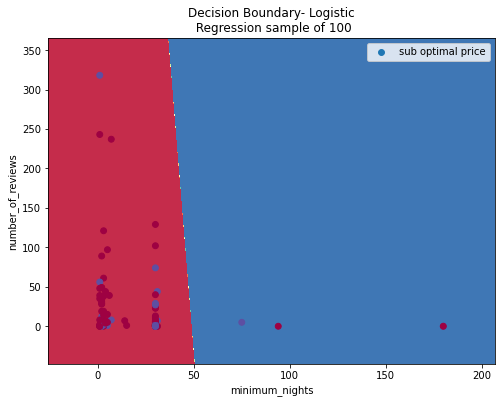

In [107]:
model = LogisticRegression(solver='newton-cg')
model.fit(X[['minimum_nights','number_of_reviews']].values, target.values)

samp = X.sample(100)
plot_decision_boundary(model,
    samp[['minimum_nights','number_of_reviews']].values,
                       pd.DataFrame(target).loc[samp.index,:].values)
plt.title('Decision Boundary- Logistic\n Regression sample of 100')
plt.xlabel('minimum_nights')
plt.ylabel('number_of_reviews')
plt.legend()

# Data analysis 

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import sidetable as stb
import numpy as np
import seaborn as sns
from scipy import stats as st
import statsmodels as sts
%matplotlib inline

In [109]:
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df2 = pd.read_csv(csv_URL)


In [110]:
print(df2.neighbourhood.nunique())
print(df2.neighbourhood_group.nunique())
print(df2.room_type.nunique())
print(df2.last_review.nunique)

244
5
4
<bound method IndexOpsMixin.nunique of 0        2022-07-18
1        2018-10-19
2        2019-11-12
3               NaN
4        2022-07-11
            ...    
39876    2019-09-16
39877    2022-08-24
39878    2022-08-22
39879           NaN
39880    2021-10-25
Name: last_review, Length: 39881, dtype: object>


In [111]:
# nominal data doesn't have any impact on price, so dropped few columns
df2 = df2.drop(["neighbourhood","last_review","host_name","host_id","id","license",'reviews_per_month','license','name'],axis=1)

In [112]:
df2 = df2.drop(['latitude','longitude'],axis=1)

In [113]:
df2.shape

(39881, 8)

In [114]:
df2.describe()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,39881.000000,39881.000000,39881.000000,39881.000000,39881.000000,39881.000000
mean,197.547228,19.131742,26.690855,16.931396,131.535669,7.754344
std,353.332542,31.432778,56.256044,59.597136,138.539399,18.784149
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,80.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,130.000000,14.000000,5.000000,1.000000,75.000000,1.000000
75%,219.000000,30.000000,25.000000,4.000000,277.000000,7.000000
max,16500.000000,1250.000000,1480.000000,453.000000,365.000000,949.000000


In [115]:
bins = np.arange(df2.price.min(), 2000+20, 20)

(array([5.400e+01, 1.385e+03, 3.810e+03, 4.633e+03, 4.462e+03, 3.364e+03,
        3.204e+03, 3.101e+03, 2.282e+03, 1.960e+03, 1.703e+03, 1.135e+03,
        1.330e+03, 7.950e+02, 7.590e+02, 7.570e+02, 5.340e+02, 5.520e+02,
        3.420e+02, 3.350e+02, 4.690e+02, 2.140e+02, 3.130e+02, 1.780e+02,
        2.100e+02, 2.100e+02, 1.010e+02, 1.270e+02, 6.500e+01, 8.300e+01,
        9.900e+01, 5.500e+01, 9.300e+01, 5.000e+01, 4.900e+01, 7.200e+01,
        3.600e+01, 7.100e+01, 3.300e+01, 4.700e+01, 6.000e+01, 2.100e+01,
        3.200e+01, 9.000e+00, 2.700e+01, 3.800e+01, 1.800e+01, 1.800e+01,
        1.000e+01, 3.200e+01, 8.000e+01, 1.100e+01, 1.000e+01, 7.000e+00,
        4.000e+00, 1.500e+01, 7.000e+00, 7.000e+00, 5.000e+00, 5.000e+00,
        2.800e+01, 1.100e+01, 1.500e+01, 8.000e+00, 1.000e+01, 1.500e+01,
        3.000e+00, 6.000e+00, 3.000e+00, 2.000e+00, 1.200e+01, 5.000e+00,
        5.000e+00, 4.000e+00, 8.000e+00, 3.000e+01, 4.000e+00, 6.000e+00,
        3.000e+00, 2.000e+00, 4.000e+0

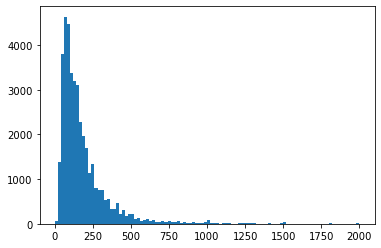

In [116]:
plt.hist(df2.price,bins=bins)

In [117]:
df2 = df2[df2['price'] <= 500]

In [118]:
df2['price'].describe(percentiles=[0.1, 0.2, 0.3, 0.5])

count    38027.000000
mean       153.847740
std        102.364744
min          0.000000
10%         50.000000
20%         70.000000
30%         85.000000
50%        125.000000
max        500.000000
Name: price, dtype: float64

(array([ 3188., 11156.,  7776.,  6135.,  3312.,  2410.,  1456.,  1064.,
          802.,   728.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <BarContainer object of 10 artists>)

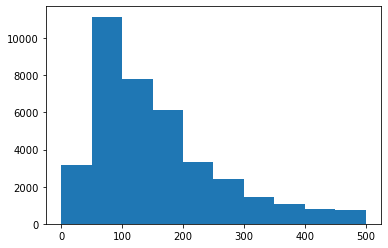

In [119]:
plt.hist(df2.price)

Naive bayes algorithm solves classification problems. But in this dataset classification won't be an easy task. With regression we can predict price, dataset we filtered for our analysis doesn't look appropriate for predicting mode price of any new neighbourhood. However, we tried to predict the price.

In [120]:
def add_column(df2_p):
    price_class=[]
    for i in df2_p:
        if i<250:
            price_class.append(1)
        else:
            price_class.append(0)
    price_class = pd.Series(price_class)
    return price_class

 Dividing the price's into 2 classes using above and adding an new column 'PriceClass'

In [121]:
df2=pd.concat([df2,pd.DataFrame(add_column(df2.price))],axis=1)

In [122]:
# added Price class column for classification algorithm
df2.rename(columns={0:'PriceClass'},inplace=1)

In [123]:
df2.dropna(inplace=True)

In [124]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36272 entries, 0 to 38026
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             36272 non-null  object 
 1   room_type                       36272 non-null  object 
 2   price                           36272 non-null  float64
 3   minimum_nights                  36272 non-null  float64
 4   number_of_reviews               36272 non-null  float64
 5   calculated_host_listings_count  36272 non-null  float64
 6   availability_365                36272 non-null  float64
 7   number_of_reviews_ltm           36272 non-null  float64
 8   PriceClass                      36272 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.8+ MB


In [125]:
#for classification
import sklearn as skl
from sklearn.naive_bayes import MultinomialNB
X = pd.get_dummies(data=df2.drop('price', axis=1), 
                   columns=['room_type','neighbourhood_group'],
                   prefix = ['room_type','neighbourhood_group'])

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36272 entries, 0 to 38026
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   minimum_nights                     36272 non-null  float64
 1   number_of_reviews                  36272 non-null  float64
 2   calculated_host_listings_count     36272 non-null  float64
 3   availability_365                   36272 non-null  float64
 4   number_of_reviews_ltm              36272 non-null  float64
 5   PriceClass                         36272 non-null  float64
 6   room_type_Entire home/apt          36272 non-null  uint8  
 7   room_type_Hotel room               36272 non-null  uint8  
 8   room_type_Private room             36272 non-null  uint8  
 9   room_type_Shared room              36272 non-null  uint8  
 10  neighbourhood_group_Bronx          36272 non-null  uint8  
 11  neighbourhood_group_Brooklyn       36272 non-null  uin

In [126]:
# for regression
import sklearn as skl
from sklearn.naive_bayes import MultinomialNB
X_reg = pd.get_dummies(data=df2, 
                   columns=['room_type','neighbourhood_group'],
                   prefix = ['room_type','neighbourhood_group'])

X_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36272 entries, 0 to 38026
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   price                              36272 non-null  float64
 1   minimum_nights                     36272 non-null  float64
 2   number_of_reviews                  36272 non-null  float64
 3   calculated_host_listings_count     36272 non-null  float64
 4   availability_365                   36272 non-null  float64
 5   number_of_reviews_ltm              36272 non-null  float64
 6   PriceClass                         36272 non-null  float64
 7   room_type_Entire home/apt          36272 non-null  uint8  
 8   room_type_Hotel room               36272 non-null  uint8  
 9   room_type_Private room             36272 non-null  uint8  
 10  room_type_Shared room              36272 non-null  uint8  
 11  neighbourhood_group_Bronx          36272 non-null  uin

In [127]:
y_reg = df2['price'].copy()
y_reg.head()

0    308.0
1    299.0
2    425.0
3     60.0
4     75.0
Name: price, dtype: float64

In [128]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
minimum_nights,36272.0,19.675369,31.582903,1.0,2.0,30.0,30.0,1250.0
number_of_reviews,36272.0,27.270650,56.881777,0.0,1.0,6.0,26.0,1480.0
calculated_host_listings_count,36272.0,16.213470,57.001963,1.0,1.0,1.0,3.0,453.0
availability_365,36272.0,123.257940,135.843738,0.0,0.0,64.0,262.0,365.0
number_of_reviews_ltm,36272.0,7.828794,18.673565,0.0,0.0,1.0,7.0,949.0
PriceClass,36272.0,0.831220,0.374563,0.0,1.0,1.0,1.0,1.0
room_type_Entire home/apt,36272.0,0.554753,0.497000,0.0,0.0,1.0,1.0,1.0
room_type_Hotel room,36272.0,0.004356,0.065857,0.0,0.0,0.0,0.0,1.0
room_type_Private room,36272.0,0.426417,0.494563,0.0,0.0,0.0,1.0,1.0
room_type_Shared room,36272.0,0.014474,0.119436,0.0,0.0,0.0,0.0,1.0


In [129]:
y = df2['PriceClass'].copy()
y.head()

0    0.0
1    0.0
2    0.0
3    1.0
4    1.0
Name: PriceClass, dtype: float64

In [130]:
#for classification
from sklearn.model_selection import train_test_split

# 20-80%  split
train_y,test_y,train_X,test_X = train_test_split(y, X,
                                                 test_size=0.2,
                                                 random_state=123)

In [131]:
# for regression
from sklearn.model_selection import train_test_split

# 20-80% simple split
train_y_reg,test_y_reg,train_X_reg,test_X_reg = train_test_split(y_reg, X_reg,
                                                 test_size=0.2,
                                                 random_state=123)

In [132]:
train_X_reg.shape

(29017, 16)

In [133]:
train_X.shape

(29017, 15)

In [134]:
from sklearn import preprocessing

# Create a scaler to do the transformation
scaler = preprocessing.MinMaxScaler().fit(train_X)

In [135]:
from sklearn import preprocessing

# Create a scaler_reg to do the transformation
scaler_reg = preprocessing.MinMaxScaler().fit(train_X_reg)

In [136]:
# Transform training X_reg
train_X_scale_reg = scaler_reg.transform(train_X_reg)
train_X_scale_reg = pd.DataFrame(train_X_scale_reg)
train_X_scale_reg.columns = train_X_reg.columns


In [137]:
# Transform training X
train_X_scale = scaler.transform(train_X)
train_X_scale = pd.DataFrame(train_X_scale)
train_X_scale.columns = train_X.columns


In [138]:
# Transform test X_reg
test_X_scale_reg = scaler_reg.transform(test_X_reg)
test_X_scale_reg = pd.DataFrame(test_X_scale_reg)
test_X_scale_reg.columns = test_X_reg.columns


In [139]:
# Transform test X
test_X_scale = scaler.transform(test_X)
test_X_scale = pd.DataFrame(test_X_scale)
test_X_scale.columns = test_X.columns


In [140]:
print(train_X.shape)
print(train_y.shape)
print(test_y.shape)
print(test_X.shape)
print(train_y)

(29017, 15)
(29017,)
(7255,)
(7255, 15)
13792    1.0
24639    1.0
18191    0.0
36636    1.0
33394    1.0
        ... 
7984     1.0
15817    1.0
18314    0.0
29214    1.0
16189    1.0
Name: PriceClass, Length: 29017, dtype: float64


In [141]:
df2.shape

(36272, 9)

In [142]:
#K-nn Regression
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor()
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(train_X_reg,train_y_reg)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)})

In [143]:
gridsearch.best_params_

{'n_neighbors': 4}

In [144]:
knn_reg=KNeighborsRegressor(4)
knn_reg.fit(train_X_reg,train_y_reg)

KNeighborsRegressor(n_neighbors=4)

### The best neighbor is 4, using neighbor 4 for model prediction and calculating Accuracy score

In [145]:
pred_y_reg=knn_reg.predict(test_X_scale_reg)

In [146]:
print('k=4 Accuracy=',knn_reg.score(test_X_scale_reg,pred_y_reg))

k=4 Accuracy= 1.0


Using GridSearch for tuning the performance

In [147]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds_grid = gridsearch.predict(train_X_reg)
train_mse = mean_squared_error(train_y_reg, train_preds_grid)
train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch.predict(test_X_reg)
test_mse = mean_squared_error(test_y_reg, test_preds_grid)
test_rmse = sqrt(test_mse)
print('RMSE_train:',train_rmse)

print('RMSE_test:',test_rmse)

RMSE_train: 3.8009924600412295
RMSE_test: 4.581871621227666


 RSME error rates are very high. Which implies that performing K-nn regression did not show any good results.
 

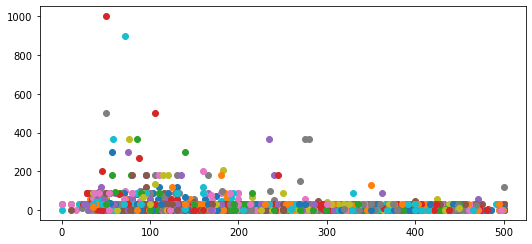

In [148]:
# scatter plot using test variables
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
xs = test_X_reg['price']
ys = test_X_reg['minimum_nights']
for x, y in zip(xs, ys):
   plt.scatter(x, y, cmap="copper")
plt.show()

In [149]:
train_preds_grid

array([148.  , 450.75, 298.75, ..., 105.25,  99.25,  69.25])

We performed classification based on price by converting price into 2 classes i.e less than 250 & greater than 250. 
used new variable called PriceClass to classify two classes.
There was a class imbalance for greater and lower price when we 500 as the marginal value for both the classes.
As greater than 500 very less in number compared to below 500. Majorly, in above 500 class there were very less
values away from 500 compared to values nearer 500.
To handle class imbalance values above 500 were removed as they are less in number.

In [150]:
# function for plotting confusion matrix
import matplotlib.pyplot as plt
import numpy as np
def print_cm(cm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Class 1','Class 2']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']] 
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [151]:
#K-NN 
from sklearn import neighbors

# KNN: K=5, default measure of distance (euclidean)
knn5 = neighbors.KNeighborsClassifier(n_neighbors=5)

In [152]:
knn5.fit(train_X_scale, train_y)


KNeighborsClassifier()

In [153]:
pred_y_knn5 = knn5.predict(test_X_scale)

In [154]:
from sklearn import metrics

# Print confusion matrix
cm = metrics.confusion_matrix(test_y, pred_y_knn5)
print(cm)

[[1203    1]
 [   0 6051]]


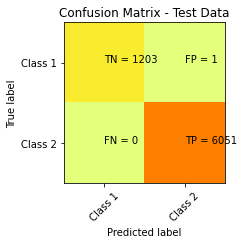

In [155]:
print_cm(cm)

In [156]:
print(metrics.classification_report(test_y, pred_y_knn5))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1204
         1.0       1.00      1.00      1.00      6051

    accuracy                           1.00      7255
   macro avg       1.00      1.00      1.00      7255
weighted avg       1.00      1.00      1.00      7255



Here we can see in the confusion matrix TN=1203, Tp=6051, FP=1,FN=0
Classification metrics shows the results are 100% correct
 Which implies the model is not correct fit.


In [157]:
# Calculate classification accuracy
metrics.accuracy_score(test_y, pred_y_knn5)

0.9998621640248104

In [158]:
for k in range(20):
    k = k + 1
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, 
                                         weights='uniform', 
                                         algorithm='auto')
    knn.fit(train_X_scale, train_y)
    pred_y = knn.predict(test_X_scale)
    print("AUC is ", round(metrics.roc_auc_score(test_y, pred_y)*100,2),"% for k =",k)

AUC is  100.0 % for k = 1
AUC is  100.0 % for k = 2
AUC is  99.96 % for k = 3
AUC is  99.96 % for k = 4
AUC is  99.96 % for k = 5
AUC is  99.96 % for k = 6
AUC is  99.96 % for k = 7
AUC is  99.96 % for k = 8
AUC is  99.96 % for k = 9
AUC is  99.96 % for k = 10
AUC is  99.96 % for k = 11
AUC is  100.0 % for k = 12
AUC is  99.96 % for k = 13
AUC is  99.96 % for k = 14
AUC is  99.96 % for k = 15
AUC is  99.96 % for k = 16
AUC is  99.96 % for k = 17
AUC is  99.96 % for k = 18
AUC is  99.96 % for k = 19
AUC is  99.96 % for k = 20


Tune the performance of K using Accuracy

In [159]:
for k in range(20):
    k = k + 1
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, 
                                         weights='uniform', 
                                         algorithm='auto')
    knn.fit(train_X_scale, train_y)
    pred_y = knn.predict(test_X_scale)
    print("Accuracy is ", metrics.accuracy_score(test_y, pred_y)*100,"% for k =",k)

Accuracy is  100.0 % for k = 1
Accuracy is  100.0 % for k = 2
Accuracy is  99.98621640248105 % for k = 3
Accuracy is  99.98621640248105 % for k = 4
Accuracy is  99.98621640248105 % for k = 5
Accuracy is  99.98621640248105 % for k = 6
Accuracy is  99.98621640248105 % for k = 7
Accuracy is  99.98621640248105 % for k = 8
Accuracy is  99.98621640248105 % for k = 9
Accuracy is  99.98621640248105 % for k = 10
Accuracy is  99.98621640248105 % for k = 11
Accuracy is  100.0 % for k = 12
Accuracy is  99.98621640248105 % for k = 13
Accuracy is  99.98621640248105 % for k = 14
Accuracy is  99.98621640248105 % for k = 15
Accuracy is  99.98621640248105 % for k = 16
Accuracy is  99.98621640248105 % for k = 17
Accuracy is  99.98621640248105 % for k = 18
Accuracy is  99.98621640248105 % for k = 19
Accuracy is  99.98621640248105 % for k = 20


We can see the optimal parameter is 2. We got the same parameter when we used GridSearch for the regression

In [160]:
for k in range(20):
    k = k + 1
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, 
                                         weights='uniform', 
                                         algorithm='auto')
    knn.fit(train_X_scale, train_y)
    pred_y = knn.predict(test_X_scale)
    print("Accuracy is ", metrics.accuracy_score(test_y, pred_y)*100,"% for k =",k)

Accuracy is  100.0 % for k = 1
Accuracy is  100.0 % for k = 2
Accuracy is  99.98621640248105 % for k = 3
Accuracy is  99.98621640248105 % for k = 4
Accuracy is  99.98621640248105 % for k = 5
Accuracy is  99.98621640248105 % for k = 6
Accuracy is  99.98621640248105 % for k = 7
Accuracy is  99.98621640248105 % for k = 8
Accuracy is  99.98621640248105 % for k = 9
Accuracy is  99.98621640248105 % for k = 10
Accuracy is  99.98621640248105 % for k = 11
Accuracy is  100.0 % for k = 12
Accuracy is  99.98621640248105 % for k = 13
Accuracy is  99.98621640248105 % for k = 14
Accuracy is  99.98621640248105 % for k = 15
Accuracy is  99.98621640248105 % for k = 16
Accuracy is  99.98621640248105 % for k = 17
Accuracy is  99.98621640248105 % for k = 18
Accuracy is  99.98621640248105 % for k = 19
Accuracy is  99.98621640248105 % for k = 20


Using AUC, best parameter is k=2. Will see the performance of k=2 in this model

In [161]:
knn_final = neighbors.KNeighborsClassifier(n_neighbors = 2, 
                                      weights='uniform',                                    
                                      algorithm='auto')
knn_final.fit(train_X_scale, train_y)
pred_y_knn_final = knn_final.predict(test_X_scale)

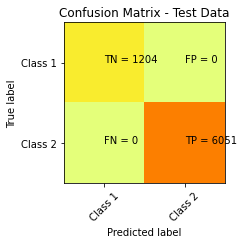

In [162]:
# Print confusion matrix
print_cm(metrics.confusion_matrix(test_y, pred_y_knn_final))

In [163]:
# Calculate classification accuracy
metrics.accuracy_score(test_y, pred_y_knn_final)

1.0

In [164]:
# Calculate AUC
metrics.roc_auc_score(test_y, pred_y_knn_final)

1.0

In [165]:
# Calculate Cohen's Kappa
metrics.cohen_kappa_score(test_y, pred_y_knn_final)

1.0

In [166]:
# Print classification report
print(metrics.classification_report(test_y, pred_y_knn_final))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1204
         1.0       1.00      1.00      1.00      6051

    accuracy                           1.00      7255
   macro avg       1.00      1.00      1.00      7255
weighted avg       1.00      1.00      1.00      7255



In [167]:
# comparing both the models

In [168]:
acc = [metrics.accuracy_score(test_y, pred_y_knn5),
       metrics.accuracy_score(test_y, pred_y_knn_final)]

pre = [metrics.precision_score(test_y, pred_y_knn5),
       metrics.precision_score(test_y, pred_y_knn_final)]

rec = [metrics.recall_score(test_y, pred_y_knn5),
       metrics.recall_score(test_y, pred_y_knn_final)]

f1  = [metrics.f1_score(test_y, pred_y_knn5),
       metrics.f1_score(test_y, pred_y_knn_final)]

In [169]:
pd.DataFrame({'Accuracy':acc, 'Precision':pre, 'Recall':rec, 'F1 Score': f1},
             index = ['k-NN (k=4)','k-NN (k=2)'])

,Accuracy,Precision,Recall,F1 Score
k-NN (k=4),0.999862,0.999835,1.0,0.999917
k-NN (k=2),1.000000,1.000000,1.0,1.000000


Compared with the kNN with k=2, the kNN model with k=2 has a higher accuracy and precision but equal recall.100% Recall at 
k=2 means that Recall at K for any K>1 is also 100%.

In [170]:
from sklearn.neighbors import KNeighborsClassifier
k = KNeighborsClassifier(n_neighbors=5)
k.fit(train_X, train_y)
y_pred = knn.predict(test_X)
print(metrics.accuracy_score(test_y, y_pred))

0.8621640248104755


In [171]:
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for i in k_range:
    k = KNeighborsClassifier(n_neighbors=i)
    k.fit(train_X, train_y)
    y_pred = k.predict(train_X)
    ex=metrics.accuracy_score(test_y, pred_y_knn_final)
    scores.append(ex)

In [172]:
print(scores)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Text(0, 0.5, 'Testing Accuracy')

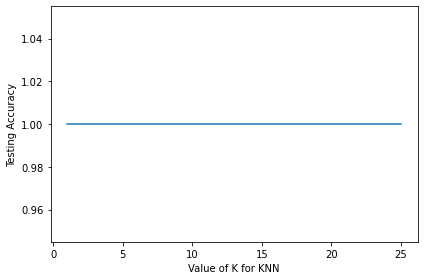

In [173]:
import matplotlib.pyplot as plt

%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

- Training accuracy rises as model complexity increases.
- Testing accuracy penalizes models that are too complex or not complex enough
- For KNN models, complexity is determined by the value of K (lower value = more complex)

### Naive Bayes classification

Whether a host is charging a fair amount is something we want to know. To accomplish this, we first arrange the observations by neighborhood before determining the average cost. In each neighborhood, hosts who charge at or above this amount are regarded as optimal, but hosts who charge below the neighborhood average are seen as sub-optimal. If every host in a neighborhood charges the same fee, the mean, mode, and median represent uniform data with no variance. The best hosts would be those who are nearby.

Alternately, we've tried using ZipCodes to analyze the data instead of using neighborhoods. For the same ZipCodes have been pulled up with the help of latitudes and longitudes and using a technique Geocoding. It is the process of transforming a description of a location (such as a physical address, or a name of a place) into a pair of latitude and longitude on the Earth's surface for that place.

It also refers to converting geographic coordinates to a description of a location (such as an address), this is often called reverse geocoding. In this tutorial, we will learn how to do both with the help of the GeoPy library in Python.



In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import sidetable as stb
import numpy as np
# import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import seaborn as sb
from scipy import stats as st
import statsmodels as sts
import statsmodels.api as sm

%matplotlib inline

Started using two files and creating a new dataframe adding the zipcodes column for analysis. 

In [175]:
d1=pd.read_csv("Brooklyn_zipcodes.csv")
d2=pd.read_csv("Manhattan_zipcodes.csv")
df2 = pd.concat([d1,d2])

In [176]:
df2. columns. values. tolist() 

['Unnamed: 0',
 'id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'number_of_reviews_ltm',
 'license',
 'ZipCodes',
 'review']

In [177]:
df2.sample(5)

,Unnamed: 0,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,...,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,ZipCodes,review
3092,6663,10098019.0,1 spacious minimalist Room in a 2 bedroom apt,17501091,Sheng-Min,Manhattan,Harlem,40.81030,-73.94704,Private room,...,30,0,NaN,NaN,2,0,0,NaN,10027.0,0
7301,16936,32568567.0,Sonder at The Nash | Studio Apartment,219517861,Sonder (NYC),Manhattan,Murray Hill,40.74772,-73.97411,Entire home/apt,...,2,206,8/24/22,4.96,71,319,107,NaN,10016.0,1
4578,10723,18875022.0,"Four-bedroom, 1,800-sq-ft loft in Park Slope",259787,Heather,Brooklyn,South Slope,40.66852,-73.98645,Entire home/apt,...,30,5,9/1/20,0.08,1,0,0,NaN,NaN,0
10850,25257,48559749.0,"Private & Quiet, Enjoyable staying away from home",62025273,Alex,Manhattan,East Harlem,40.79016,-73.94943,Entire home/apt,...,30,2,5/18/22,0.15,3,249,1,NaN,10029.0,0
2632,5803,8994197.0,1 Bedroom in the heart of Greenwich Village / SoHo,4974196,Dan,Manhattan,Greenwich Village,40.72708,-74.00012,Entire home/apt,...,30,2,11/25/17,0.03,1,0,0,NaN,10012.0,0


In [178]:
df2.describe()

,Unnamed: 0,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,ZipCodes,review
count,31692.000000,3.169200e+04,3.169200e+04,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,24866.000000,31692.000000,31692.000000,31692.000000,20479.000000,31692.000000
mean,19072.854506,1.063137e+17,1.188996e+08,40.725295,-73.963851,214.810047,20.485233,25.661113,1.120183,17.638047,121.128329,7.102550,10352.955467,0.261170
std,11538.048573,2.381332e+17,1.420285e+08,0.053204,0.028928,377.397039,32.548342,55.958150,1.978491,62.814198,135.105459,19.055758,533.169905,0.439279
min,0.000000,2.539000e+03,2.438000e+03,40.574130,-74.058610,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,10000.000000,0.000000
25%,8863.750000,1.390583e+07,1.034821e+07,40.686677,-73.986980,87.000000,2.000000,1.000000,0.120000,1.000000,0.000000,0.000000,10016.000000,0.000000
50%,18735.500000,3.554305e+07,4.754619e+07,40.720590,-73.961950,148.000000,30.000000,5.000000,0.450000,1.000000,61.000000,0.000000,10028.000000,0.000000
75%,28950.250000,5.190263e+07,1.945077e+08,40.761530,-73.944510,240.000000,30.000000,23.000000,1.560000,4.000000,260.000000,5.000000,11206.000000,1.000000
max,39880.000000,7.096930e+17,4.781609e+08,40.878210,-73.858140,16500.000000,1250.000000,1480.000000,123.000000,453.000000,365.000000,949.000000,11385.000000,1.000000


In [179]:
df2['review'].value_counts()

0    23415
1     8277
Name: review, dtype: int64

In [180]:
X = pd.get_dummies(data=df2.drop('number_of_reviews', axis=1), 
                   columns=['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'number_of_reviews_ltm',
 'license',
 'ZipCodes',
 'review'],
prefix =['id','name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'number_of_reviews_ltm',
 'license',
 'ZipCodes',
 'review'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31692 entries, 0 to 16846
Columns: 127708 entries, Unnamed: 0 to review_1
dtypes: int64(1), uint8(127707)
memory usage: 3.8 GB


In [181]:
X.describe()

,Unnamed: 0,id_2539.0,id_2595.0,id_5121.0,id_5136.0,id_5178.0,id_5203.0,id_5803.0,id_6848.0,id_6872.0,...,ZipCodes_11235.0,ZipCodes_11236.0,ZipCodes_11237.0,ZipCodes_11238.0,ZipCodes_11239.0,ZipCodes_11249.0,ZipCodes_11251.0,ZipCodes_11385.0,review_0,review_1
count,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,...,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000,31692.000000
mean,19072.854506,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,...,0.002619,0.004165,0.006058,0.006563,0.000252,0.006216,0.000252,0.000063,0.738830,0.261170
std,11538.048573,0.005617,0.005617,0.005617,0.005617,0.005617,0.005617,0.005617,0.005617,0.005617,...,0.051109,0.064404,0.077600,0.080748,0.015886,0.078598,0.015886,0.007944,0.439279,0.439279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8863.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18735.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,28950.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,39880.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In our analysis we performed PCA on the normalized data, showing the dataset's most significant variables. The data's information content is scattered. There don't appear to be any notable variability clusters. The scree plot and the cumulative variability measurements show this. 

Then we have started analyzing the data with the average reviews or reviews per month since with the KNN clustering as well we have found that the data cannot be classified to find the reason for prices not being steady. 

In [182]:
y = df2['review'].copy()
y.replace(['1','0'],[1,0],inplace=True)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: review, dtype: int64

In [183]:
from sklearn.model_selection import train_test_split

train_y,test_y,train_X,test_X = train_test_split(y, X,
                                                 test_size=0.2,
                                                 random_state=123)

In [184]:
train_X.shape

(25353, 127708)

In [185]:
train_y.shape

(25353,)

In [186]:
from sklearn import naive_bayes
gauss_nb = naive_bayes.GaussianNB()

In [187]:
gauss_nb.fit(train_X, train_y)

GaussianNB()

In [188]:
pred_y_gnb = gauss_nb.predict(test_X)

In [189]:
from sklearn import neighbors

knn5 = neighbors.KNeighborsClassifier(n_neighbors=5)

In [190]:
knn5.fit(train_X, train_y)

KNeighborsClassifier()

In [191]:
pred_y_knn5 = knn5.predict(test_X)

In [192]:
from sklearn import metrics

cm = metrics.confusion_matrix(test_y, pred_y_knn5)
print(cm)

[[4178  530]
 [1135  496]]


In [193]:
import matplotlib.pyplot as plt
import numpy as np
def print_cm(cm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']] 
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

The Nave Bayes classifier makes the assumption that the values of each feature are independent of one another. To estimate the classification-related parameters, naive Bayes classifiers need training data. Naive Bayes classifiers can be used in a variety of real-world situations due to their straightforward design and implementation.

By replacing the parameters with the new input value for the variable, one can use the Gaussian probability density function to make predictions. As a result, the Gaussian function will provide an estimate for the probability of the new input value.

So we entered all the information and added a reference column for monthly reviews for classification, which gave us a high degree of accuracy demonstrating that the reason for price inconsistency is related to the location of the property and its surroundings as well as how the guests felt during their stay.

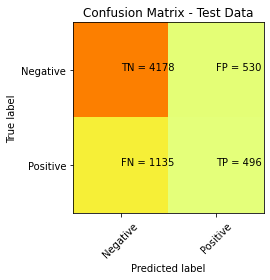

In [194]:
print_cm(cm)

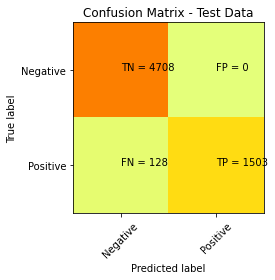

In [195]:
print_cm(metrics.confusion_matrix(test_y, pred_y_gnb))

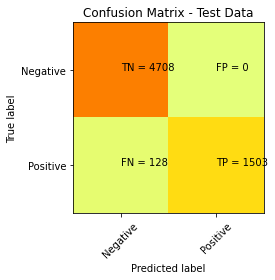

In [196]:
print_cm(metrics.confusion_matrix(test_y, pred_y_gnb))

In [197]:
metrics.roc_auc_score(test_y, pred_y_gnb)

0.9607602697731453

In [198]:
metrics.cohen_kappa_score(test_y, pred_y_gnb)

0.9457757604433146

In [199]:
print(metrics.classification_report(test_y, pred_y_gnb))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4708
           1       1.00      0.92      0.96      1631

    accuracy                           0.98      6339
   macro avg       0.99      0.96      0.97      6339
weighted avg       0.98      0.98      0.98      6339



## Conclusion

The algorithms underlying any prediction model should distinguish between different types of rooms. Due to the relatively small amount of data, individual rooms and apartments appear to be the most relevant in terms of business analytics, whereas hotels and shared rooms may be less so.

The above classification demonstrates that customer reviews are more significant in determining price. It is assumed that properties closer to Manhattan or other well-known attractions will, on average, have higher list prices because the majority of reviews mention the neighborhood, how accessible and close they are to popular destinations, as well as how comfortable and spacious they are.

 # NYC AirBnB Data Principle Component Analysis

## Step-1: Import Packages,  Data Exploration & Cleaning
Intent should be to maximize information content while minimizing the number of dimensions or variables in the datset. Most of the variables in the dataframe have non null values except 'last_review', 'reviews_per_month', and 'license'. These columns are believed to have either little information value, or are believed to have other variables that would explain their effects anyway. Thus the aforementioned columns were removed. In addition all observations with zero values in the 'price' column were removed. It is assumed that the 'price'  will be the primary variable of interest.

In [202]:
pip install plotly

     |████████████████████████████████| 15.3 MB 6.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [203]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import seaborn as sb
import plotly.express as px

In [204]:
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df= pd.read_csv(csv_URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39881 entries, 0 to 39880
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39881 non-null  int64  
 1   name                            39868 non-null  object 
 2   host_id                         39881 non-null  int64  
 3   host_name                       39831 non-null  object 
 4   neighbourhood_group             39881 non-null  object 
 5   neighbourhood                   39881 non-null  object 
 6   latitude                        39881 non-null  float64
 7   longitude                       39881 non-null  float64
 8   room_type                       39881 non-null  object 
 9   price                           39881 non-null  int64  
 10  minimum_nights                  39881 non-null  int64  
 11  number_of_reviews               39881 non-null  int64  
 12  last_review                     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39851 entries, 0 to 39880
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39851 non-null  int64  
 1   neighbourhood_group             39851 non-null  object 
 2   latitude                        39851 non-null  float64
 3   longitude                       39851 non-null  float64
 4   room_type                       39851 non-null  object 
 5   price                           39851 non-null  int64  
 6   minimum_nights                  39851 non-null  int64  
 7   number_of_reviews               39851 non-null  int64  
 8   calculated_host_listings_count  39851 non-null  int64  
 9   availability_365                39851 non-null  int64  
 10  number_of_reviews_ltm           39851 non-null  int64  
 11  lat_lon                         39851 non-null  float64
dtypes: float64(3), int64(7), object(

None

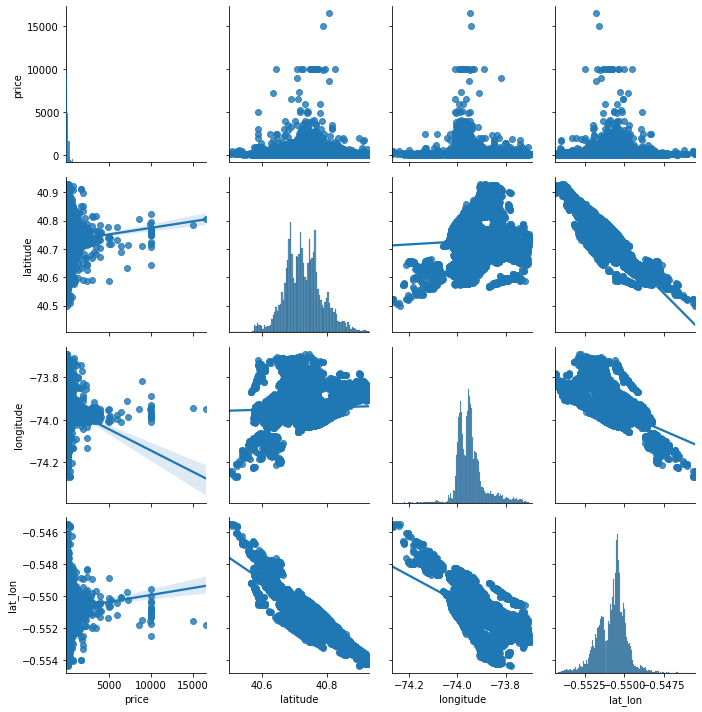

In [205]:
# remove deemed to be less than useful
df['lat_lon']= df['latitude']/df['longitude']
df = df.drop(['license', 'reviews_per_month','last_review', 'name', 'host_id','neighbourhood', 'host_name'],axis = 1)
df = df.loc[(df['price']> 0)]# Remove all zero values from the price
display(df.info())
sb.pairplot(df[['price','latitude','longitude','lat_lon']], kind="reg")
plt.show()

The pairplot was developed to gain an understanding of the relationship between 'latitiude', 'longitude', and 'price'. Based on this visualization, that correlation appears to be weak.

# Step 2: Determine & Remove the Outliers
Process was to remove all outliers larger than q3 + (1.5 * IQR), or less than or equal to the minimum. In addition the latitude and longitude columns were removed from the dataset and replaced with the transformation 'lat_lon', which is the ratio latitude to longitude. The result reduced the number of observations in the data from 39881 to 36524.

In [206]:
df_stats = df.groupby('room_type')['price'].describe()
df_stats.reindex()
display(df_stats)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,22761.0,251.546022,338.044654,10.0,128.00,180.0,275.0,15000.0
Hotel room,172.0,436.470930,282.491141,100.0,258.75,308.0,501.5,1998.0
Private room,16361.0,122.936495,356.373737,10.0,55.00,75.0,110.0,16500.0
Shared room,557.0,119.398564,454.106078,10.0,42.00,66.0,92.0,10000.0


In [207]:
# Create Table with outliers
df_stats['IQR'] = df_stats["75%"]- df_stats["25%"]
df_stats['upper_outlier'] = df_stats["75%"] + (1.5 * df_stats['IQR'])
df_stats['lower_outlier'] = df_stats["25%"] - (1.5 * df_stats['IQR'])
display(df_stats)

,count,mean,std,min,25%,50%,75%,max,IQR,upper_outlier,lower_outlier
room_type,,,,,,,,,,,
Entire home/apt,22761.0,251.546022,338.044654,10.0,128.00,180.0,275.0,15000.0,147.00,495.500,-92.500
Hotel room,172.0,436.470930,282.491141,100.0,258.75,308.0,501.5,1998.0,242.75,865.625,-105.375
Private room,16361.0,122.936495,356.373737,10.0,55.00,75.0,110.0,16500.0,55.00,192.500,-27.500
Shared room,557.0,119.398564,454.106078,10.0,42.00,66.0,92.0,10000.0,50.00,167.000,-33.000


,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1530.0,108.036601,68.561010,10.0,60.0,89.0,135.00,450.0
Brooklyn,14192.0,133.914459,88.425233,10.0,69.0,110.0,175.00,529.0
Manhattan,14426.0,180.040690,105.605595,10.0,100.0,150.0,235.00,826.0
Queens,5954.0,114.189620,79.028227,10.0,60.0,90.0,145.00,495.0
Staten Island,422.0,113.646919,61.827482,33.0,69.0,99.5,140.75,412.0


,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,21117.0,196.250793,95.382230,10.0,125.0,175.0,250.0,496.0
Hotel room,155.0,363.490323,163.471288,100.0,248.5,307.0,470.0,826.0
Private room,14751.0,78.448648,34.294310,10.0,52.0,72.0,97.0,192.0
Shared room,501.0,66.179641,32.916921,10.0,40.0,60.0,85.0,165.0


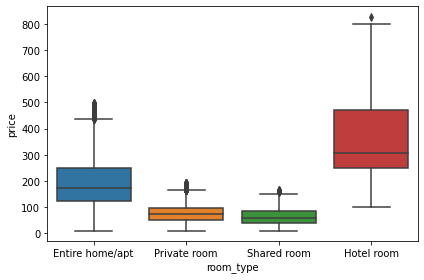

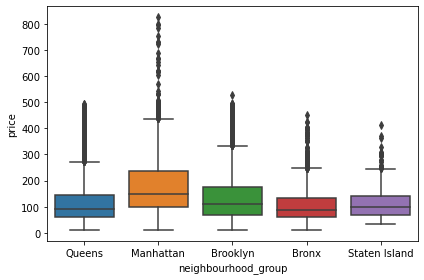

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36524 entries, 2 to 19816
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              36524 non-null  int64  
 1   neighbourhood_group             36524 non-null  object 
 2   latitude                        36524 non-null  float64
 3   longitude                       36524 non-null  float64
 4   room_type                       36524 non-null  object 
 5   price                           36524 non-null  int64  
 6   minimum_nights                  36524 non-null  int64  
 7   number_of_reviews               36524 non-null  int64  
 8   calculated_host_listings_count  36524 non-null  int64  
 9   availability_365                36524 non-null  int64  
 10  number_of_reviews_ltm           36524 non-null  int64  
 11  lat_lon                         36524 non-null  float64
dtypes: float64(3), int64(7), object(

None

,id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,lat_lon
id,1.000000,-0.006021,0.090372,0.100288,-0.114942,-0.187285,0.041516,0.295017,-0.084761,-0.036796
latitude,-0.006021,1.000000,0.057068,0.023211,0.033942,-0.032738,0.031671,-0.021543,-0.042166,-0.886394
longitude,0.090372,0.057068,1.000000,-0.221445,-0.099553,0.040181,-0.063658,0.143466,0.077105,-0.512761
price,0.100288,0.023211,-0.221445,1.000000,-0.088323,-0.000474,0.152782,0.155715,0.082033,0.082805
minimum_nights,-0.114942,0.033942,-0.099553,-0.088323,1.000000,-0.147075,0.124210,-0.054423,-0.234587,0.017041
number_of_reviews,-0.187285,-0.032738,0.040181,-0.000474,-0.147075,1.000000,-0.096784,0.089859,0.629522,0.009497
calculated_host_listings_count,0.041516,0.031671,-0.063658,0.152782,0.124210,-0.096784,1.000000,0.131778,-0.059441,0.002320
availability_365,0.295017,-0.021543,0.143466,0.155715,-0.054423,0.089859,0.131778,1.000000,0.160993,-0.048121
number_of_reviews_ltm,-0.084761,-0.042166,0.077105,0.082033,-0.234587,0.629522,-0.059441,0.160993,1.000000,0.000450
lat_lon,-0.036796,-0.886394,-0.512761,0.082805,0.017041,0.009497,0.002320,-0.048121,0.000450,1.000000


In [208]:
df1 = df[(df['room_type'] == "Entire home/apt") & (df['price']>=10) & (df['price']<= 496)]
df2 = df[(df['room_type'] == "Private room") & (df['price']>= 10) & (df['price']<= 192)]
df3 = df[(df['room_type'] == "Shared room") & (df['price']>= 10) & (df['price']<= 167)] 
df4 = df[(df['room_type'] == "Hotel room") & (df['price']>= 100) & (df['price']<= 865)]
frames = [df1, df2, df3, df4]
df = pd.concat(frames)

display(df.groupby('neighbourhood_group')['price'].describe())
display(df.groupby('room_type')['price'].describe())
sb.boxplot(y = df['price'], x = df['room_type'])
plt.show()
sb.boxplot(y = df['price'], x = df['neighbourhood_group'])
plt.show()
display(df.info())
display(df.corr())

In [209]:
df_select = df[['price','lat_lon','neighbourhood_group','room_type', 'minimum_nights', 'number_of_reviews','calculated_host_listings_count','availability_365','number_of_reviews_ltm']]
df_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36524 entries, 2 to 19816
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           36524 non-null  int64  
 1   lat_lon                         36524 non-null  float64
 2   neighbourhood_group             36524 non-null  object 
 3   room_type                       36524 non-null  object 
 4   minimum_nights                  36524 non-null  int64  
 5   number_of_reviews               36524 non-null  int64  
 6   calculated_host_listings_count  36524 non-null  int64  
 7   availability_365                36524 non-null  int64  
 8   number_of_reviews_ltm           36524 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 3.8+ MB


# Step 3:  Incorporate Categorical Variables into the Data and Scale the Dataset
The purpose of this step was to incorporate room type and neighborhood or NYC burrough into the dataset as "dummy variables" using one hot encoding. Also conducted during this step was a targeted correlation between price and the remaining variables.The strongest positive correlations were room types of 'Entire home/apt', neighborhood groups of 'Manhattan' and 365 day availability. Strongest negative correlation was a room type of "Private room". Finally the dataset was normalized.

In [210]:
 # One-hot encode the neighbourhood_group column
dfx = pd.concat([df_select,
               pd.get_dummies(df_select['neighbourhood_group'])],axis=1)


In [211]:
 # One-hot encode the room_type column
X = pd.concat([dfx,
               pd.get_dummies(dfx['room_type'])],axis=1)
            
# Drop the original categorical column and the response variable
df = X.drop(['neighbourhood_group','room_type'], axis=1)
display(df.info())
display(df[df.columns[0:]].corr()['price'][:].sort_values(ascending=False).to_frame())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36524 entries, 2 to 19816
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           36524 non-null  int64  
 1   lat_lon                         36524 non-null  float64
 2   minimum_nights                  36524 non-null  int64  
 3   number_of_reviews               36524 non-null  int64  
 4   calculated_host_listings_count  36524 non-null  int64  
 5   availability_365                36524 non-null  int64  
 6   number_of_reviews_ltm           36524 non-null  int64  
 7   Bronx                           36524 non-null  uint8  
 8   Brooklyn                        36524 non-null  uint8  
 9   Manhattan                       36524 non-null  uint8  
 10  Queens                          36524 non-null  uint8  
 11  Staten Island                   36524 non-null  uint8  
 12  Entire home/apt                 

None

,price
price,1.000000
Entire home/apt,0.585895
Manhattan,0.269626
availability_365,0.155715
calculated_host_listings_count,0.152782
Hotel room,0.144978
lat_lon,0.082805
number_of_reviews_ltm,0.082033
number_of_reviews,-0.000474
Staten Island,-0.037760


In [212]:
X = scale(df)# Normalize the data
display(pd.DataFrame(X).describe().transpose())# Display the normalize data statistics
corr_ = pd.DataFrame(X).corr() #Display the correlation matrix for the normalized data
pd.DataFrame(corr_).style.background_gradient(cmap = 'YlOrRd')

,count,mean,std,min,25%,50%,75%,max
0,36524.0,5.539893e-15,1.000014,-1.415415,-0.746793,-0.283901,0.436153,6.978363
1,36524.0,9.434973e-14,1.000014,-3.783566,-0.643971,0.177789,0.568060,5.630077
2,36524.0,-1.498075e-14,1.000014,-0.587472,-0.556147,0.258299,0.320948,38.537241
3,36524.0,3.666876e-16,1.000014,-0.489330,-0.471433,-0.381952,-0.024027,25.997131
4,36524.0,-1.983690e-14,1.000014,-0.263174,-0.263174,-0.263174,-0.228420,7.591338
5,36524.0,7.306705e-15,1.000014,-0.932757,-0.932757,-0.429781,1.028121,1.727913
6,36524.0,7.110498e-15,1.000014,-0.472989,-0.472989,-0.411815,-0.044770,53.849669
7,36524.0,4.900318e-14,1.000014,-0.209098,-0.209098,-0.209098,-0.209098,4.782457
8,36524.0,2.021351e-15,1.000014,-0.797183,-0.797183,-0.797183,1.254417,1.254417
9,36524.0,-1.425716e-14,1.000014,-0.807972,-0.807972,-0.807972,1.237666,1.237666


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.082805,-0.088323,-0.000474,0.152782,0.155715,0.082033,-0.085095,-0.112220,0.269626,-0.151669,-0.037760,0.585895,0.144978,-0.585485,-0.098770
1,0.082805,1.000000,0.017041,0.009497,0.002320,-0.048121,0.000450,-0.492280,0.576398,-0.236596,-0.273398,0.321136,0.088623,-0.000014,-0.083587,-0.023660
2,-0.088323,0.017041,1.000000,-0.147075,0.124210,-0.054423,-0.234587,-0.060490,-0.018337,0.099410,-0.064700,-0.034070,-0.006647,-0.028905,0.010089,0.001815
3,-0.000474,0.009497,-0.147075,1.000000,-0.096784,0.089859,0.629522,0.006102,0.025945,-0.055635,0.030901,0.017911,0.022851,0.044267,-0.026437,-0.010235
4,0.152782,0.002320,0.124210,-0.096784,1.000000,0.131778,-0.059441,-0.046750,-0.101159,0.114416,0.014788,-0.025462,0.014032,0.001746,-0.008779,-0.023518
5,0.155715,-0.048121,-0.054423,0.089859,0.131778,1.000000,0.160993,0.102307,-0.075341,-0.060966,0.105373,0.066505,0.055361,0.044967,-0.064226,0.010751
6,0.082033,0.000450,-0.234587,0.629522,-0.059441,0.160993,1.000000,0.026521,0.002098,-0.073314,0.071627,0.028496,0.050213,0.022147,-0.049378,-0.017275
7,-0.085095,-0.492280,-0.060490,0.006102,-0.046750,0.102307,0.026521,1.000000,-0.166689,-0.168945,-0.092280,-0.022607,-0.044166,-0.013651,0.042079,0.017640
8,-0.112220,0.576398,-0.018337,0.025945,-0.101159,-0.075341,0.002098,-0.166689,1.000000,-0.644102,-0.351815,-0.086188,-0.048267,-0.047722,0.058642,-0.015778
9,0.269626,-0.236596,0.099410,-0.055635,0.114416,-0.060966,-0.073314,-0.168945,-0.644102,1.000000,-0.356577,-0.087355,0.153711,0.069598,-0.165311,0.005835


# Step 4: Principal Component Analysis
The PCA was conducted on the normalized data and indicate the following results:
- The most important variables in the dataset are 'price', 'Manhattan', 'Entire home/apt', and 'Private room'
- The least significant variables seem to be 'Hotel room' and 'Queens'.
- Information content in the data is dispersed. There dont seem to be any significant clusters of variability. As indicated by the scree plot and the measures of the cumulative variability, you dont get above 90% of the variability explained until you get to 11 of the 16 principal components. Once you get to roughly 13 principal components, marginal variability apears to go to zero. As evidenced by the correlation matrices and the heatmaps, most of the variables could be considered to have a significant component loading depending on the dimension in which they are viewed. The practical effect of this seems to be that action taken to reduce the dimensionality of the dataset won't add any significant benefits.

In [213]:
# Select the number of components
pca1 = PCA(n_components=16)
# Fit the PCA model
pca1.fit(X)

PCA(n_components=16)

In [214]:
#The amount of variance that each PC explains
var = pca1.explained_variance_ratio_
display(var)

array([1.65195096e-01, 1.34942542e-01, 1.17200904e-01, 8.08398602e-02,
       7.70139078e-02, 6.83907993e-02, 6.70856015e-02, 6.42368108e-02,
       6.33128426e-02, 5.42576742e-02, 4.61935056e-02, 2.61700494e-02,
       2.17283626e-02, 1.34320435e-02, 8.75402690e-33, 3.98756864e-33])

In [215]:
#Cumulative Variance explains
var1 = np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)
display(var1)

array([16.52, 30.01, 41.73, 49.81, 57.51, 64.35, 71.06, 77.48, 83.81,
       89.24, 93.86, 96.48, 98.65, 99.99, 99.99, 99.99])

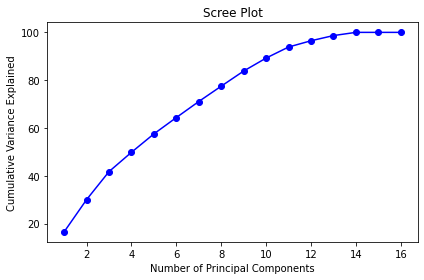

In [216]:
var1 = pd.DataFrame(var1, index=np.arange(1,17))
plt.plot(var1,'-o',color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.savefig('scree_plot.png',dpi=100,bbox_inches='tight')
plt.show()

In [217]:
# Select the number of components
pca16 = PCA(n_components=16)
pca16.fit(X)
data_pca16 = pca16.transform(X)

# Convert the numpy array to pandas DataFrame
data_pca16 = pd.DataFrame(data_pca16)
data_pca16.columns = ["PC"+str(i) for i in range(1,17)]

# Show the head of the DataFrame
display(data_pca16.head())
display(data_pca16.corr())


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,1.985462,-0.577469,0.687516,-1.269858,-2.613957,-0.497312,-0.356578,0.348281,-0.725955,0.259770,-1.033230,1.721738,-1.038442,0.247408,-6.678685e-17,3.608225e-16
1,1.649282,-0.675217,-0.170214,0.425239,-0.003942,0.126435,0.262893,-0.061995,0.360419,0.214147,-1.145967,-0.686522,-0.364044,0.242477,-3.720982e-16,-1.942890e-16
2,1.295075,2.063616,-0.424649,-0.932033,-0.293281,0.386445,-0.234463,0.151246,-0.287277,-0.102477,-0.403823,0.576902,-0.259064,0.234949,1.647987e-17,-1.942890e-16
3,0.623319,1.974616,-0.481647,-0.789052,0.378923,-0.226539,-0.271675,0.031405,0.009326,0.479975,0.344678,-0.244835,-0.305966,0.151578,1.647987e-17,-3.053113e-16
4,1.784482,-0.174928,2.224686,1.621296,0.475536,0.107636,-0.095550,-0.043105,1.363229,1.097498,-1.097350,-1.618384,-2.879385,0.585529,-1.593344e-15,1.387779e-16


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
PC1,1.000000e+00,8.699958e-17,-2.160003e-16,8.914926e-16,-7.615422e-16,9.425875e-16,-3.479700e-16,1.794978e-16,1.105682e-17,1.300278e-15,-3.506589e-16,1.095432e-15,-6.561741e-16,-2.194467e-16,0.082972,-0.039135
PC2,8.699958e-17,1.000000e+00,-6.194808e-16,8.754322e-17,-1.064284e-16,-2.401440e-16,-4.131187e-16,-4.583873e-17,-1.376281e-16,6.237909e-16,-2.811118e-16,-9.393265e-17,-2.187264e-16,-8.275827e-16,-0.076828,-0.171439
PC3,-2.160003e-16,-6.194808e-16,1.000000e+00,-9.296778e-17,-3.223494e-17,-2.235751e-16,-4.604777e-16,1.486528e-16,-5.613883e-16,-1.402904e-16,1.716487e-16,8.235693e-17,-4.324706e-16,-6.353161e-16,0.133189,0.519051
PC4,8.914926e-16,8.754322e-17,-9.296778e-17,1.000000e+00,-3.463333e-17,2.635182e-16,-5.246262e-17,1.527832e-16,4.840310e-16,-6.221858e-16,2.088693e-16,-4.756621e-16,-8.684138e-16,2.099810e-16,-0.461351,0.310300
PC5,-7.615422e-16,-1.064284e-16,-3.223494e-17,-3.463333e-17,1.000000e+00,7.614412e-16,2.737876e-16,2.903215e-16,-2.990381e-16,2.361765e-17,1.971624e-16,-3.149009e-16,-2.681475e-16,-6.949858e-16,0.092209,-0.146271
PC6,9.425875e-16,-2.401440e-16,-2.235751e-16,2.635182e-16,7.614412e-16,1.000000e+00,-3.809112e-16,4.768600e-16,1.857375e-15,7.669664e-16,-4.616602e-16,9.100785e-16,-4.043594e-16,3.143747e-16,-0.016825,0.053529
PC7,-3.479700e-16,-4.131187e-16,-4.604777e-16,-5.246262e-17,2.737876e-16,-3.809112e-16,1.000000e+00,1.350709e-16,9.224731e-16,1.532660e-16,1.897431e-16,-2.200056e-16,6.240599e-16,-7.969947e-17,0.483577,-0.183705
PC8,1.794978e-16,-4.583873e-17,1.486528e-16,1.527832e-16,2.903215e-16,4.768600e-16,1.350709e-16,1.000000e+00,1.149665e-16,-4.178798e-16,-3.781141e-16,1.230682e-16,-2.387798e-16,1.581737e-16,-0.275212,0.115971
PC9,1.105682e-17,-1.376281e-16,-5.613883e-16,4.840310e-16,-2.990381e-16,1.857375e-15,9.224731e-16,1.149665e-16,1.000000e+00,-1.168364e-15,-8.431149e-18,-2.886245e-17,-5.709356e-16,1.775388e-16,-0.296321,0.128752
PC10,1.300278e-15,6.237909e-16,-1.402904e-16,-6.221858e-16,2.361765e-17,7.669664e-16,1.532660e-16,-4.178798e-16,-1.168364e-15,1.000000e+00,-9.045023e-16,-5.591272e-16,-5.330469e-16,4.936010e-16,0.072500,0.075723


All pairwise combinations are cose to zero which is indicative of no multicollinearity among principal components.


In [218]:
# Show the loadings for the 1st components
pca16.components_[[0]]

array([[ 0.49436566,  0.04118856, -0.01297004,  0.02628435,  0.08448953,
         0.0832199 ,  0.05627946, -0.06993217, -0.13351556,  0.27544056,
        -0.15112606,  0.0024715 ,  0.55148041,  0.05822177, -0.55213588,
        -0.04485018]])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
price,0.494366,0.019726,0.024750,0.013123,-0.082987,0.118820,-0.118382,0.012789,-0.142628,-0.134824,-0.003869,0.757667,-0.312720,-0.094119,-0.000000,0.000000
lat_lon,0.041189,0.592048,-0.107348,0.218596,-0.141812,-0.011429,0.087850,0.017217,-0.002317,-0.033825,-0.022378,0.042853,-0.000951,0.746145,0.000000,-0.000000
minimum_nights,-0.012970,-0.037755,-0.347262,0.050110,-0.093974,0.040430,-0.133461,0.018612,0.394311,0.796024,-0.103264,0.212317,0.040142,-0.013854,-0.000000,0.000000
number_of_reviews,0.026284,0.071200,0.552707,0.273389,0.175848,-0.049760,-0.104132,-0.007327,0.228779,0.221871,0.094714,-0.212012,-0.643504,0.011531,-0.000000,0.000000
calculated_host_listings_count,0.084490,-0.094115,-0.140241,0.169653,-0.455272,0.337139,-0.288567,0.030013,0.324731,-0.235346,0.581545,-0.173810,0.017159,-0.030162,-0.000000,-0.000000
availability_365,0.083220,-0.065082,0.247721,-0.046817,-0.452562,0.447795,0.051175,0.099129,0.112693,-0.059676,-0.680342,-0.168357,-0.003885,-0.004160,-0.000000,0.000000
number_of_reviews_ltm,0.056279,0.057868,0.594665,0.230606,0.089309,-0.016554,-0.090609,-0.020525,0.197982,0.054122,0.081691,0.260563,0.673028,-0.011755,0.000000,0.000000
Bronx,-0.069932,-0.277898,0.158760,-0.456528,0.241822,0.490120,0.220642,-0.137241,0.047105,0.114314,0.233853,0.109733,-0.035246,0.417605,-0.236597,-0.066459
Brooklyn,-0.133516,0.584626,-0.021376,-0.215595,0.127282,0.192071,-0.233596,0.084471,0.035789,-0.027639,-0.014284,-0.016206,0.006306,-0.344373,-0.575642,-0.161694
Manhattan,0.275441,-0.341754,-0.218352,0.498337,0.244525,-0.034873,0.055357,-0.037286,0.086747,-0.137065,-0.183061,-0.104373,0.051653,0.113467,-0.577320,-0.162165


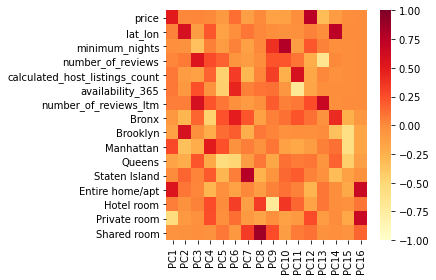

In [219]:
corr_16 = pd.DataFrame(pca16.components_.transpose(),
             index=df.loc[:,'price':'Shared room'].columns,
             columns=["PC"+str(i) for i in range(1,17)])
display(pd.DataFrame(corr_16).style.background_gradient(cmap = 'YlOrRd'))
ax = sb.heatmap(corr_16, annot=False, cmap = 'YlOrRd', vmin = -1, vmax = 1)
plt.show()

Intent should be to maximize information content while minimizing the number of dimensions or variables in the datset. Most of the variables in the dataframe have non null values except 'last_review', 'reviews_per_month', and 'license'. These columns are believed to have either little information value, or are believed to have other variables that would explain their effects anyway. Thus the aforementioned columns were removed. In addition all observations with zero values in the 'price' column were removed. The data columns 'accommodates', 'bedrooms', and 'beds' from the "listings-2.csv" dataset were merged with the primary "listings.csv" data. It is assumed that the 'price' will be the primary variable of interest.

In [221]:

df_listings = pd.read_csv('listings.csv')
df_listings2 = pd.read_csv('listings-2.csv')
df_listings2 = df_listings2[['id','accommodates', 'bedrooms', 'beds']]
df_merged=df_listings.merge(df_listings2, on='id',how = 'inner')
df = df_merged
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39881 entries, 0 to 39880
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39881 non-null  int64  
 1   name                            39868 non-null  object 
 2   host_id                         39881 non-null  int64  
 3   host_name                       39831 non-null  object 
 4   neighbourhood_group             39881 non-null  object 
 5   neighbourhood                   39881 non-null  object 
 6   latitude                        39881 non-null  float64
 7   longitude                       39881 non-null  float64
 8   room_type                       39881 non-null  object 
 9   price                           39881 non-null  int64  
 10  minimum_nights                  39881 non-null  int64  
 11  number_of_reviews               39881 non-null  int64  
 12  last_review                     

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (68) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [222]:
# remove deemed to be less than useful
df = df.drop(['license', 'reviews_per_month','last_review', 'name', 'host_id','neighbourhood', 'host_name'],axis = 1)
df = df.loc[(df['price']> 0)]# Remove all zero values from the price


In [223]:
df_stats = df.groupby('room_type')['price'].describe()
df_stats.reindex()
display(df_stats)


,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,22761.0,251.546022,338.044654,10.0,128.00,180.0,275.0,15000.0
Hotel room,172.0,436.470930,282.491141,100.0,258.75,308.0,501.5,1998.0
Private room,16361.0,122.936495,356.373737,10.0,55.00,75.0,110.0,16500.0
Shared room,557.0,119.398564,454.106078,10.0,42.00,66.0,92.0,10000.0


In [224]:
# Create Table with outliers
df_stats['IQR'] = df_stats["75%"]- df_stats["25%"]
df_stats['upper_outlier'] = df_stats["75%"] + (1.5 * df_stats['IQR'])
df_stats['lower_outlier'] = df_stats["25%"] - (1.5 * df_stats['IQR'])
display(df_stats)

,count,mean,std,min,25%,50%,75%,max,IQR,upper_outlier,lower_outlier
room_type,,,,,,,,,,,
Entire home/apt,22761.0,251.546022,338.044654,10.0,128.00,180.0,275.0,15000.0,147.00,495.500,-92.500
Hotel room,172.0,436.470930,282.491141,100.0,258.75,308.0,501.5,1998.0,242.75,865.625,-105.375
Private room,16361.0,122.936495,356.373737,10.0,55.00,75.0,110.0,16500.0,55.00,192.500,-27.500
Shared room,557.0,119.398564,454.106078,10.0,42.00,66.0,92.0,10000.0,50.00,167.000,-33.000


In [225]:
df1 = df[(df['room_type'] == "Entire home/apt") & (df['price']>=10) & (df['price']<= 496)]
df2 = df[(df['room_type'] == "Private room") & (df['price']>= 10) & (df['price']<= 192)]
df3 = df[(df['room_type'] == "Shared room") & (df['price']>= 10) & (df['price']<= 167)] 
df4 = df[(df['room_type'] == "Hotel room") & (df['price']>= 100) & (df['price']<= 865)]
frames = [df1, df2, df3, df4]
df_frames = pd.concat(frames)
df = df_frames.dropna()

In [226]:

df_select = df[['price','accommodates', 'beds', 'bedrooms','neighbourhood_group','room_type', 'minimum_nights', 'number_of_reviews','calculated_host_listings_count','availability_365','number_of_reviews_ltm']]
df_select.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32379 entries, 2 to 19816
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           32379 non-null  int64  
 1   accommodates                    32379 non-null  int64  
 2   beds                            32379 non-null  float64
 3   bedrooms                        32379 non-null  float64
 4   neighbourhood_group             32379 non-null  object 
 5   room_type                       32379 non-null  object 
 6   minimum_nights                  32379 non-null  int64  
 7   number_of_reviews               32379 non-null  int64  
 8   calculated_host_listings_count  32379 non-null  int64  
 9   availability_365                32379 non-null  int64  
 10  number_of_reviews_ltm           32379 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 3.0+ MB


In [227]:
df_a = pd.concat([df_select,
               pd.get_dummies(df_select['neighbourhood_group'])],axis=1)


In [228]:
 # One-hot encode the room_type column
X = pd.concat([df_a,
               pd.get_dummies(df_select['room_type'])],axis=1)


In [229]:
df = X.drop(['neighbourhood_group','room_type'], axis=1)
display(df.info())
display(df[df.columns[0:]].corr()['price'][:].sort_values(ascending=False).to_frame())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32379 entries, 2 to 19816
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           32379 non-null  int64  
 1   accommodates                    32379 non-null  int64  
 2   beds                            32379 non-null  float64
 3   bedrooms                        32379 non-null  float64
 4   minimum_nights                  32379 non-null  int64  
 5   number_of_reviews               32379 non-null  int64  
 6   calculated_host_listings_count  32379 non-null  int64  
 7   availability_365                32379 non-null  int64  
 8   number_of_reviews_ltm           32379 non-null  int64  
 9   Bronx                           32379 non-null  uint8  
 10  Brooklyn                        32379 non-null  uint8  
 11  Manhattan                       32379 non-null  uint8  
 12  Queens                          

None

,price
price,1.000000
Entire home/apt,0.607875
accommodates,0.522097
bedrooms,0.422809
beds,0.397797
Manhattan,0.264734
availability_365,0.158387
Hotel room,0.153587
calculated_host_listings_count,0.138000
number_of_reviews_ltm,0.079055


In [230]:
X = scale(df)# Normalize the data
display(pd.DataFrame(X).describe().transpose())# Display the normalize data statistics
corr_ = pd.DataFrame(X).corr() #Display the correlation matrix for the normalized data
pd.DataFrame(corr_).style.background_gradient(cmap = 'YlOrRd')


,count,mean,std,min,25%,50%,75%,max
0,32379.0,5.108007e-16,1.000015,-1.384487,-0.727566,-0.272776,0.444783,6.862388
1,32379.0,5.061863e-14,1.000015,-1.037749,-0.471594,-0.471594,0.660715,7.454570
2,32379.0,-8.664168e-14,1.000015,-0.586236,-0.586236,-0.586236,0.388386,21.830072
3,32379.0,1.742541e-14,1.000015,-0.489507,-0.489507,-0.489507,-0.489507,18.068097
4,32379.0,-7.568670e-15,1.000015,-0.569068,-0.538195,0.017514,0.326241,37.990941
5,32379.0,-2.061979e-15,1.000015,-0.498317,-0.480370,-0.390637,-0.013758,17.627779
6,32379.0,-9.048595e-15,1.000015,-0.253004,-0.253004,-0.253004,-0.217735,7.717764
7,32379.0,1.033406e-14,1.000015,-0.937184,-0.937184,-0.428522,1.039332,1.715125
8,32379.0,-1.143874e-14,1.000015,-0.510749,-0.510749,-0.445015,0.015123,20.326924
9,32379.0,1.036295e-14,1.000015,-0.212743,-0.212743,-0.212743,-0.212743,4.700517


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.000000,0.522097,0.397797,0.422809,-0.085153,-0.002248,0.138000,0.158387,0.079055,-0.082539,-0.104841,0.264734,-0.147348,-0.035411,0.607875,0.153587,-0.606871,-0.100743
1,0.522097,1.000000,0.769320,0.719106,-0.077999,0.079875,-0.092212,0.134116,0.126751,0.015564,0.006826,-0.032474,0.012452,0.040686,0.540947,-0.011040,-0.520288,-0.088523
2,0.397797,0.769320,1.000000,0.745591,-0.055318,0.083606,-0.090776,0.127355,0.113085,0.016075,0.011066,-0.064884,0.042509,0.060060,0.400668,-0.015412,-0.397842,-0.010391
3,0.422809,0.719106,0.745591,1.000000,-0.030931,0.009797,-0.063453,0.101947,0.055105,0.006153,0.046943,-0.074503,0.019080,0.040580,0.379796,-0.032347,-0.362468,-0.060047
4,-0.085153,-0.077999,-0.055318,-0.030931,1.000000,-0.143420,0.131208,-0.061766,-0.246215,-0.060267,-0.009962,0.091479,-0.061656,-0.034078,-0.018914,-0.030389,0.022159,0.003947
5,-0.002248,0.079875,0.083606,0.009797,-0.143420,1.000000,-0.097199,0.087777,0.617163,0.004540,0.017353,-0.044534,0.026912,0.017295,0.024102,0.049438,-0.028357,-0.010498
6,0.138000,-0.092212,-0.090776,-0.063453,0.131208,-0.097199,1.000000,0.118627,-0.064573,-0.046455,-0.090110,0.094373,0.028928,-0.024786,0.000450,0.002211,0.004841,-0.022937
7,0.158387,0.134116,0.127355,0.101947,-0.061766,0.087777,0.118627,1.000000,0.172682,0.107527,-0.077823,-0.067708,0.109646,0.070090,0.060712,0.048270,-0.070437,0.011911
8,0.079055,0.126751,0.113085,0.055105,-0.246215,0.617163,-0.064573,0.172682,1.000000,0.030428,-0.000181,-0.080481,0.077513,0.032025,0.058774,0.027536,-0.058056,-0.019345
9,-0.082539,0.015564,0.016075,0.006153,-0.060267,0.004540,-0.046455,0.107527,0.030428,1.000000,-0.175682,-0.162290,-0.096719,-0.023551,-0.036400,-0.014367,0.034465,0.016595


The PCA was conducted on the normalized data and indicate the following results:

- The variables 'price','accommodates','bedrooms', and 'beds' all have a significant amount of variance.
- The room type variables with the greatest variability are 'Entire home/apt'and'Private room' which have strong positive and strong negative correlations with the price respectively.
- The neighborhood group variable with the most significant variability is 'Manhattan'. Variance surrounding the other NYC boroughs is relatively small in comarison to Manhattan.
- Information content in the data is dispersed. There is significant variance clustered around 'price','accommodates','bedrooms', and 'beds'. As indicated by the scree plot and the measures of the cumulative variability, you dont get above 90% of the variability explained until you get to 12 of the 17 principal components. Once you get to roughly 16 principal components, marginal variability apears to go to zero. As evidenced by the correlation matrices and the heatmaps, most of the variables could be considered to have a significant component loading depending on the dimension in which they are viewed. That said, based on this analysis it seems the variables with the greatest information content are 'price', 'accommodates', 'bedrooms', 'beds', 'Manhattan', and 'Private Room'. Dimensionality efficiencies could be gained by doing the following: 1)combining the other boroughs into an 'other NYC borough' category; 2) Combining 'Hotel room' and 'Shared room' into an 'other_room_type' category.

In [231]:
pca1 = PCA(n_components=17)
# Fit the PCA model
pca1.fit(X)


PCA(n_components=17)

In [232]:

#The amount of variance that each PC explains
var = pca1.explained_variance_ratio_
display(var)


array([2.14963201e-01, 1.09789549e-01, 9.33599115e-02, 7.83676048e-02,
       6.34738335e-02, 6.11369170e-02, 5.85427739e-02, 5.66393710e-02,
       5.61483876e-02, 5.37502891e-02, 4.70746999e-02, 4.08547477e-02,
       2.11736225e-02, 1.86968508e-02, 1.46210449e-02, 1.14071957e-02,
       1.63755839e-32])

In [233]:

#Cumulative Variance explains
var1 = np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)
display(var1)

array([ 21.5 ,  32.48,  41.82,  49.66,  56.01,  62.12,  67.97,  73.63,
        79.24,  84.62,  89.33,  93.42,  95.54,  97.41,  98.87, 100.01,
       100.01])

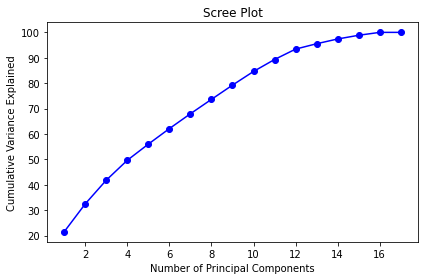

In [234]:
var1 = pd.DataFrame(var1, index=np.arange(1,18))
plt.plot(var1,'-o',color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.savefig('scree_plot.png',dpi=100,bbox_inches='tight')
plt.show()

In [235]:
pca12 = PCA(n_components=12)
pca12.fit(X)
data_pca12 = pca12.transform(X)

# Convert the numpy array to pandas DataFrame
data_pca12 = pd.DataFrame(data_pca12)
data_pca12.columns = ["PC"+str(i) for i in range(1,13)]

# Show the head of the DataFrame
display(data_pca12.head())
display(data_pca12.corr())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,10.408834,-2.344001,-1.814731,-5.718018,0.671663,-1.350063,-1.763709,1.774149,0.885797,2.998342,-1.176287,-0.015795
1,1.994100,-0.075959,-1.538568,0.421726,-0.569717,0.403489,0.094000,0.214057,0.082609,-0.331779,-0.114395,0.410393
2,3.443012,-0.979823,-2.398937,-0.372878,0.500755,-0.580506,-0.500857,0.419433,0.290769,1.196614,0.013746,-0.660340
3,0.663807,-0.231886,2.900867,1.744677,-0.329584,-0.001760,0.398493,-0.924713,-0.297534,0.969842,1.074605,1.261835
4,2.175902,-0.964989,-1.417536,0.497505,-0.131167,-0.143219,0.017889,0.008734,0.073529,0.593536,0.448348,-0.009065


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
PC1,1.000000e+00,-9.351114e-15,1.940826e-16,-5.242463e-16,-9.234118e-17,-1.957561e-16,3.349069e-16,-9.297520e-17,-7.181529e-16,-3.783056e-16,-2.219882e-16,3.416808e-16
PC2,-9.351114e-15,1.000000e+00,-2.945138e-16,3.249689e-17,-9.472619e-17,-3.646132e-16,2.719352e-16,-4.050567e-16,-3.357073e-16,1.576311e-16,-4.356564e-16,-9.640975e-17
PC3,1.940826e-16,-2.945138e-16,1.000000e+00,-6.829673e-16,3.777157e-17,4.401362e-17,8.228827e-17,-6.000349e-16,-3.622820e-16,-9.315402e-16,-1.304582e-15,-1.762682e-16
PC4,-5.242463e-16,3.249689e-17,-6.829673e-16,1.000000e+00,-1.710859e-16,6.320878e-16,-1.711259e-16,9.491678e-16,-6.011708e-16,8.560956e-17,7.187558e-16,-6.174248e-18
PC5,-9.234118e-17,-9.472619e-17,3.777157e-17,-1.710859e-16,1.000000e+00,2.546141e-16,2.996933e-16,7.271018e-16,5.240675e-16,-7.213925e-17,-1.326582e-15,-2.345434e-16
PC6,-1.957561e-16,-3.646132e-16,4.401362e-17,6.320878e-16,2.546141e-16,1.000000e+00,-4.369086e-16,-1.496860e-16,3.950431e-16,-4.205606e-16,3.044048e-16,-4.253762e-16
PC7,3.349069e-16,2.719352e-16,8.228827e-17,-1.711259e-16,2.996933e-16,-4.369086e-16,1.000000e+00,4.346577e-16,-3.525604e-16,1.921394e-15,-1.619709e-15,-1.149952e-15
PC8,-9.297520e-17,-4.050567e-16,-6.000349e-16,9.491678e-16,7.271018e-16,-1.496860e-16,4.346577e-16,1.000000e+00,1.691435e-15,-2.252640e-16,8.362764e-16,3.009591e-18
PC9,-7.181529e-16,-3.357073e-16,-3.622820e-16,-6.011708e-16,5.240675e-16,3.950431e-16,-3.525604e-16,1.691435e-15,1.000000e+00,-3.983453e-17,7.983080e-16,-6.148213e-16
PC10,-3.783056e-16,1.576311e-16,-9.315402e-16,8.560956e-17,-7.213925e-17,-4.205606e-16,1.921394e-15,-2.252640e-16,-3.983453e-17,1.000000e+00,2.925347e-16,6.165334e-16


All pairwise combinations are cose to zero which is indicative of no multicollinearity among principal components.

In [236]:
# Show the loadings for the 1st components
pca12.components_[[0]]


array([[ 0.38123082,  0.43435241,  0.39206466,  0.37877221, -0.052029  ,
         0.05694837, -0.01712033,  0.09697947,  0.09037581, -0.01045356,
        -0.02180736,  0.04854811, -0.03471025,  0.02286762,  0.41426637,
         0.01612292, -0.40842703, -0.04053656]])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
price,0.381231,0.195381,0.107851,0.109316,-0.177495,0.059470,-0.059856,0.112114,0.000190,-0.087657,-0.126942,-0.014188
accommodates,0.434352,-0.106824,-0.091441,-0.136268,0.082277,-0.057178,-0.107115,0.054155,-0.001193,0.118656,-0.040384,-0.028951
beds,0.392065,-0.153689,-0.114297,-0.213203,0.132296,-0.071519,-0.115738,0.078000,0.086328,0.254296,-0.085453,-0.072723
bedrooms,0.378772,-0.118587,-0.174499,-0.220923,0.092520,-0.070022,-0.170345,0.089047,0.046906,0.245414,-0.126858,-0.080985
minimum_nights,-0.052029,0.268078,-0.190571,-0.104596,-0.162378,-0.040987,-0.001023,-0.143054,0.024932,0.552394,0.679383,0.147426
number_of_reviews,0.056948,-0.385530,0.385737,0.313238,-0.027252,-0.132639,0.016249,-0.099255,-0.041051,0.269829,0.199854,-0.091446
calculated_host_listings_count,-0.017120,0.219913,0.100886,-0.137547,-0.629212,0.196276,0.033153,-0.131329,-0.047730,0.197620,-0.230211,-0.579571
availability_365,0.096979,-0.141438,0.228854,-0.224226,-0.344330,0.465614,0.009668,-0.034064,0.098013,0.072943,-0.140735,0.690978
number_of_reviews_ltm,0.090376,-0.416692,0.414679,0.249347,-0.079801,-0.063938,0.033220,-0.102373,-0.063984,0.153124,0.036102,-0.077412
Bronx,-0.010454,-0.102222,0.069107,-0.161622,0.360841,0.682568,-0.017487,0.078415,-0.412633,0.001263,0.228987,-0.252399


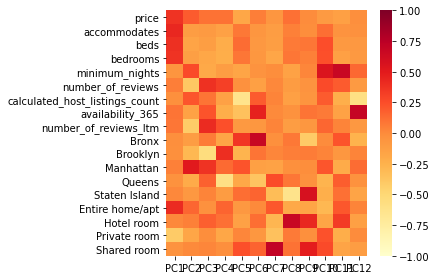

In [237]:
corr_12 = pd.DataFrame(pca12.components_.transpose(),
             index=df.loc[:,'price':'Shared room'].columns,
             columns=["PC"+str(i) for i in range(1,13)])
display(pd.DataFrame(corr_12).style.background_gradient(cmap = 'YlOrRd'))
ax = sb.heatmap(corr_12, annot=False, cmap = 'YlOrRd', vmin = -1, vmax = 1)
plt.show()


## Conclusion and TakeAways

- Average listing prices for Manhattan tend to be the highest, followed by Brooklyn, Queens, Staten Island, and the Bronx. Most of the listings are in Manhattan, Brooklyn, and Queens.


- The algorithms underlying any prediction model should distinguish between different types of rooms. Due to the relatively small amount of data, individual rooms and apartments appear to be the most relevant in terms of business analytics, whereas hotels and shared rooms may be less so.

- The above classification demonstrates that customer reviews are more significant in determining price. It is assumed that properties closer to Manhattan or other well-known attractions will, on average, have higher list prices because the majority of reviews mention the neighborhood, how accessible and close they are to popular destinations, as well as how comfortable and spacious they are.


# Technology Stack

In [238]:
!which python

/opt/anaconda3/bin/python


In [239]:
!which jupyter

/opt/anaconda3/bin/jupyter


In [240]:
!which python3

/opt/anaconda3/bin/python3


# Github Repository, Handles, and Evaluation

https://github.com/Naren1610/IST5520GrpProj/tree/milestone2

### IST5520GrpProj

<h4 align="left"> Ronald Adomako, adomakor412 </h3>
<h4 align="left"> Idris Dobbs, idobbs-2012 </h3>
<h4 align="left"> Narendra Chigili, Naren1610 </h3>
<h4 align="left"> Nikhil Srirama Sai, SaiNikhilPalaparthi </h3>